# Multi-Well Geophysical Log-Laboratory Data Integration Analysis

## Overview
This notebook performs a comprehensive cross-well analysis to identify consistent correlations and patterns between geophysical log measurements and laboratory analytical results across multiple wells in the HRDH dataset. The analysis focuses on:

- **Data Integration**: Combining and harmonizing datasets from multiple wells
- **Quality Assessment**: Evaluating data completeness and identifying missing patterns  
- **Correlation Analysis**: Finding statistically significant relationships between log and lab measurements
- **Pattern Recognition**: Identifying correlations that persist across multiple wells
- **Visualization**: Creating comprehensive heatmaps and statistical summaries

### Wells Analyzed
- HRDH_697, HRDH_1119, HRDH_1804, HRDH_1867

### Key Outputs
- Correlation matrices by well and combined
- Statistical consistency analysis
- Comprehensive visualization suite
- Exportable datasets for further analysis

# 1. Environment Setup and Library Imports

This section imports all required libraries and configures the analysis environment.

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from scipy import stats
import missingno as msno
import os
from Module import *

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Create output directory for plots
Path('imgs').mkdir(exist_ok=True)


# 2. Multi-Well Data Loading and Integration

This section loads data from all available wells, handles duplicate columns (particularly in HRDH_1867), and combines them into a unified dataset for cross-well analysis.

In [13]:
# Load all well data with duplicate column fixing
print("Loading data from all wells...")

def fix_duplicate_columns(df, well_name):
    """Fix duplicate columns by merging data from duplicates into the original column."""
    columns = df.columns.tolist()
    seen = {}
    duplicates = {}
    
    for i, col in enumerate(columns):
        if col in seen:
            if col not in duplicates:
                duplicates[col] = [seen[col]]
            duplicates[col].append(i)
        else:
            seen[col] = i
    
    if duplicates:
        print(f"\nFound duplicate columns in {well_name}:")
        for col, indices in duplicates.items():
            print(f"  - '{col}' appears at indices: {indices}")
        
        # Fix duplicates by merging data
        for col_name, indices in duplicates.items():
            dup_cols = [df.iloc[:, idx] for idx in indices]
            merged_data = dup_cols[0].copy()
            
            for dup_col in dup_cols[1:]:
                mask = merged_data.isna() & ~dup_col.isna()
                merged_data[mask] = dup_col[mask]
            
            df.iloc[:, indices[0]] = merged_data
            original_nulls = dup_cols[0].isna().sum()
            final_nulls = merged_data.isna().sum()
            recovered = original_nulls - final_nulls
            
            print(f"    Merged {len(indices)} columns named '{col_name}'")
            print(f"    Recovered {recovered} missing values")
        
        df = df.loc[:, ~df.columns.duplicated(keep='first')]
        print(f"  Removed duplicate columns")
    
    return df

def load_all_wells_csv_fixed():
    """Load all well CSV files with duplicate column fixing."""
    base_path = Path('.')
    all_data = []
    
    joined_files = list(base_path.glob('HRDH_*/HRDH_*_joined.csv'))
    
    if not joined_files:
        raise FileNotFoundError("No joined CSV files found")
    
    print(f"Found {len(joined_files)} joined CSV files:")
    for file in joined_files:
        print(f"  {file}")
    
    for file in joined_files:
        well_name = file.parent.name
        df = pd.read_csv(file)
        
        # Fix duplicate columns if present
        df = fix_duplicate_columns(df, well_name)
        
        # Add well identifier
        df['Well'] = well_name
        df.columns = df.columns.str.strip()
        
        print(f"Loaded {well_name}: {len(df)} samples, {len(df.columns)} columns")
        all_data.append(df)
    
    df_combined = pd.concat(all_data, ignore_index=True, sort=True)
    print(f"\nCombined dataset: {len(df_combined)} total samples from {len(all_data)} wells")
    print(f"Total columns after merge: {len(df_combined.columns)}")
    
    return df_combined

# Load the data
df_all = load_all_wells_csv_fixed()

# Display basic information
print(f"\nDataset shape: {df_all.shape}")
print(f"Wells included: {sorted(df_all['Well'].unique())}")
print(f"\nSamples per well:")
print(df_all['Well'].value_counts().sort_values(ascending=False))

# Check data completeness by well
print("\nData completeness by well:")
for well in sorted(df_all['Well'].unique()):
    well_data = df_all[df_all['Well'] == well]
    completeness = (1 - well_data.isnull().sum().sum() / (len(well_data) * len(well_data.columns))) * 100
    print(f"  {well}: {completeness:.1f}% complete")

df_all

Loading data from all wells...
Found 4 joined CSV files:
  HRDH_1119\HRDH_1119_joined.csv
  HRDH_1804\HRDH_1804_joined.csv
  HRDH_1867\HRDH_1867_joined.csv
  HRDH_697\HRDH_697_joined.csv
Loaded HRDH_1119: 18 samples, 73 columns
Loaded HRDH_1804: 41 samples, 56 columns
Loaded HRDH_1867: 9 samples, 59 columns
Loaded HRDH_697: 10 samples, 66 columns

Combined dataset: 78 total samples from 4 wells
Total columns after merge: 89

Dataset shape: (78, 89)
Wells included: ['HRDH_1119', 'HRDH_1804', 'HRDH_1867', 'HRDH_697']

Samples per well:
Well
HRDH_1804    41
HRDH_1119    18
HRDH_697     10
HRDH_1867     9
Name: count, dtype: int64

Data completeness by well:
  HRDH_1119: 82.0% complete
  HRDH_1804: 62.9% complete
  HRDH_1867: 66.3% complete
  HRDH_697: 74.2% complete


,Distance,Lab_Depth,Lab_Sample_ID,Lab_XRD_Anatase,Lab_XRD_Anhydrite,Lab_XRD_Ankerite,Lab_XRD_Calcite,Lab_XRD_Chlorite,Lab_XRD_Dickite,Lab_XRD_Dolomite,...,Log_TTEN,Log_U,Log_UC,Log_WRM,Log_WTBH,Log_ZCOR,Log_ZDEN,Log_ZDNC,Match_Type,Well
0,0.00,10742.5,20,NaN,98.4,0,0.0,0.0,NaN,1.5,...,4011.0398,0.243608,NaN,NaN,231.91081,-0.004835,2.946764,2.935852,Exact,HRDH_1119
1,0.10,10743.4,21,NaN,99.3,0,0.0,0.0,NaN,0.7,...,4020.7507,0.017326,NaN,NaN,232.1537,-0.009443,2.929054,2.918051,Near,HRDH_1119
2,0.05,10744.3,22,NaN,96.9,0,0.0,0.0,NaN,3.0,...,4022.0010,0.017326,NaN,NaN,232.22966,-0.013279,2.925855,2.914831,Near,HRDH_1119
3,0.10,10745.4,23,NaN,76.8,0,0.0,0.0,NaN,22.8,...,4011.2126,0.149796,NaN,NaN,231.95135,-0.021489,2.901159,2.890035,Near,HRDH_1119
4,0.00,10746.5,24,NaN,96.1,0,0.0,0.0,NaN,3.7,...,4009.1106,0.528289,NaN,NaN,232.20607,-0.014056,2.889534,2.878369,Exact,HRDH_1119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,0.20,14903.7,7,NaN,0.0,0,0.0,0.1,NaN,0.0,...,NaN,9.923880,NaN,NaN,,-0.044524,2.493208,2.482956,Near,HRDH_697
74,0.20,14905.7,8,NaN,0.0,0,0.0,0.1,NaN,0.0,...,NaN,10.382340,NaN,NaN,,-0.032361,2.427736,2.417896,Near,HRDH_697
75,0.00,14931.5,14,NaN,0.0,0,0.0,0.1,NaN,0.0,...,NaN,8.952220,NaN,NaN,,-0.059618,2.473074,2.462947,Exact,HRDH_697
76,0.10,14932.4,15,NaN,0.0,0,0.0,0.1,NaN,0.0,...,NaN,10.230805,NaN,NaN,,-0.062772,2.478785,2.468622,Near,HRDH_697


# 3. Dataset Structure Analysis and Variable Classification

This section analyzes the combined dataset structure, classifies variables into log measurements, laboratory results, and metadata, and filters to focus on specific geophysical measurements of interest.

In [14]:

# Only include specific log measurements
specific_logs = ['CN', 'CNC', 'GR', 'GRSL', 'HRD1', 'HRD2', 'K', 'KTH', 'LSN', 
                'PE', 'QPKS', 'SFT2', 'SHR', 'SLTM', 'ZDNC']

# Convert to Log_ prefixed names
specific_log_columns = [f'Log_{log}' for log in specific_logs]

# Filter columns
lab_columns = [col for col in df_all.columns if col.startswith('Lab_') and col != 'Lab_Depth' and col != 'Lab_Sample_ID']

# Only include log columns that are in the specific list
all_log_columns = [col for col in df_all.columns if col.startswith('Log_') and col != 'Log_Depth' and col != 'Log_FRAMENO']
log_columns = [col for col in all_log_columns if col in specific_log_columns]

# Check which specific logs are missing
available_logs = [col.replace('Log_', '') for col in log_columns]
missing_logs = [log for log in specific_logs if log not in available_logs]

metadata_columns = ['Lab_Depth', 'Log_Depth', 'Distance', 'Match_Type', 'Well']

# Remove Sample_ID and FRAMENO columns if they exist
columns_to_exclude = ['Lab_Sample_ID', 'Log_FRAMENO', 'Sample_ID', 'FRAMENO']

for col in columns_to_exclude:
    if col in df_all.columns:
        print(f"Excluding column: {col}")
        df_all = df_all.drop(columns=[col])

print(f"Column Classification:")
print(f"Lab measurements: {len(lab_columns)}")
print(f"Log measurements (filtered): {len(log_columns)} out of {len(specific_logs)} requested")
print(f"Available logs: {', '.join(available_logs)}")

if missing_logs:
    print(f"Missing logs: {', '.join(missing_logs)}")
print(f"Metadata: {len(metadata_columns)}")
print(f"Total columns: {len(df_all.columns)}")



Excluding column: Lab_Sample_ID
Excluding column: Log_FRAMENO
Column Classification:
Lab measurements: 35
Log measurements (filtered): 15 out of 15 requested
Available logs: CN, CNC, GR, GRSL, HRD1, HRD2, K, KTH, LSN, PE, QPKS, SFT2, SHR, SLTM, ZDNC
Metadata: 5
Total columns: 87


# 4. Data Quality Assessment and Missing Value Analysis

This section evaluates data completeness across wells, identifies patterns in missing data, and visualizes data availability to understand limitations for correlation analysis.

In [15]:
# Calculate missing data summary
missing_summary = pd.DataFrame({
    'Missing_Count': df_all.isnull().sum(),
    'Missing_Percent': (df_all.isnull().sum() / len(df_all)) * 100
}).sort_values('Missing_Percent', ascending=False)

# Identify columns with high missing data
high_missing = missing_summary[missing_summary['Missing_Percent'] > 50]

print("Top 10 columns with most missing data:")
print(missing_summary.head(10))
print(f"\nColumns with >50% missing data: {len(high_missing)}")

Top 10 columns with most missing data:
                Missing_Count  Missing_Percent
Lab_XRD_Halite             69        88.461538
Log_CNL                    69        88.461538
Log_CHT.I                  68        87.179487
Log_CALZ                   60        76.923077
Log_BVOL                   51        65.384615
Log_CVOL                   51        65.384615
Log_CHT                    51        65.384615
Lab_XRF_Fe                 50        64.102564
Lab_XRF_Mn                 50        64.102564
Lab_XRF_Mg                 50        64.102564

Columns with >50% missing data: 33


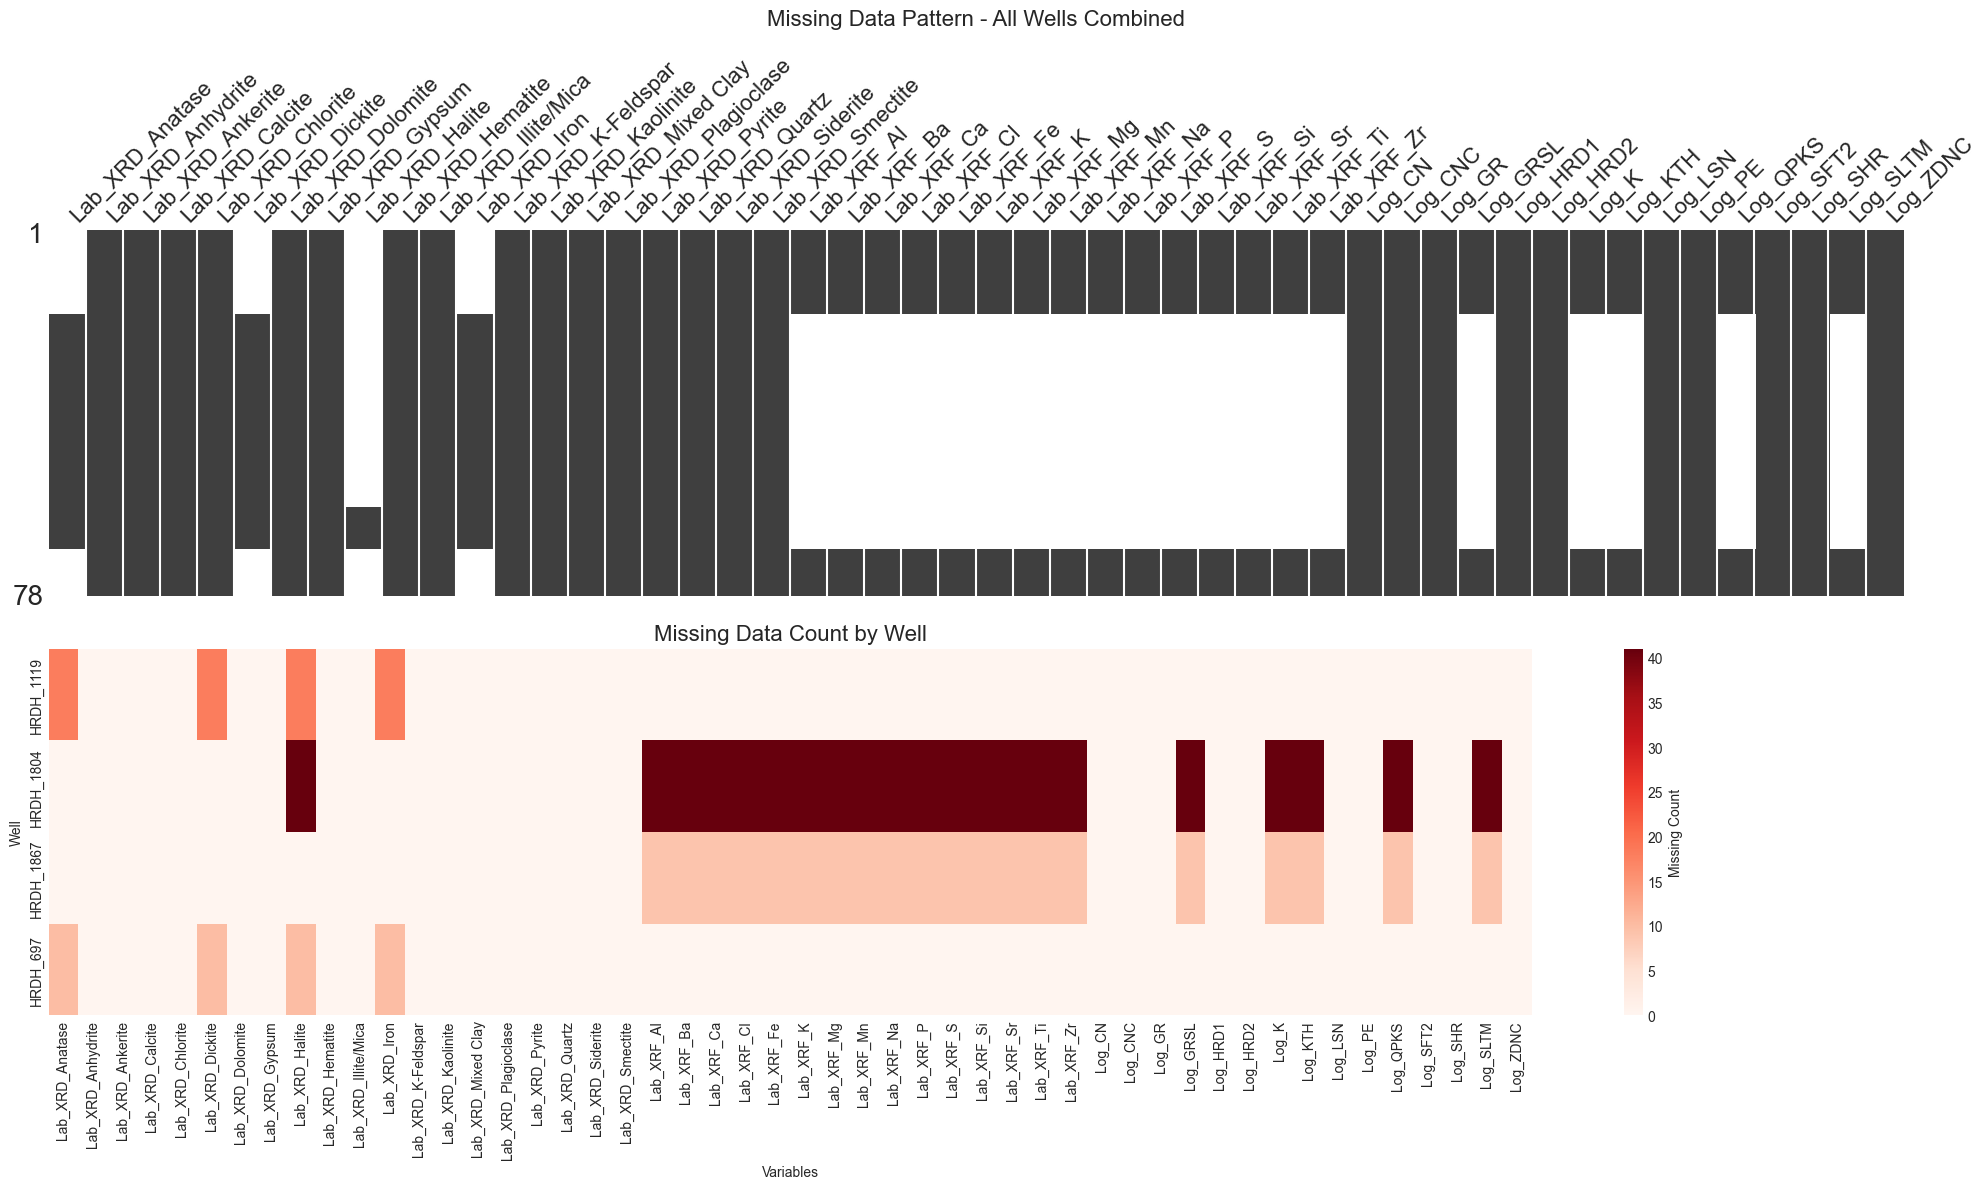

In [16]:
# Visualize missing data patterns
fig, axes = plt.subplots(2, 1, figsize=(20, 12))

# Missing data matrix
ax1 = axes[0]
msno.matrix(df_all[lab_columns + log_columns], ax=ax1, sparkline=False)
ax1.set_title('Missing Data Pattern - All Wells Combined', fontsize=16, pad=20)

# Missing data heatmap
ax2 = axes[1]
missing_by_well = df_all.groupby('Well')[lab_columns + log_columns].apply(lambda x: x.isnull().sum())
sns.heatmap(missing_by_well, cmap='Reds', ax=ax2, cbar_kws={'label': 'Missing Count'})
ax2.set_title('Missing Data Count by Well', fontsize=16)
ax2.set_xlabel('Variables')
ax2.set_ylabel('Well')

plt.tight_layout()
plt.savefig('imgs/missing_data_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# 5. Statistical Correlation Analysis and Cross-Well Pattern Recognition

This section performs comprehensive correlation analysis between log and laboratory measurements, categorizes correlations by the number of wells they appear in (2, 3, or 4 wells), and identifies the most consistent and significant relationships across the dataset.

In [17]:
def calculate_correlations_by_well(df_all, lab_columns, log_columns):
    """Calculate correlation matrices between lab and log measurements for each well."""
    well_correlations = {}
    wells = sorted(df_all['Well'].unique())
    
    for well in wells:
        well_df = df_all[df_all['Well'] == well]
        corr_matrix = pd.DataFrame(index=log_columns, columns=lab_columns, dtype=float)
        
        for log_col in log_columns:
            for lab_col in lab_columns:
                valid_mask = (~pd.isna(well_df[log_col])) & (~pd.isna(well_df[lab_col]))
                
                if valid_mask.sum() > 3:  # Need at least 3 points for correlation
                    corr_value, _ = stats.pearsonr(
                        well_df.loc[valid_mask, log_col],
                        well_df.loc[valid_mask, lab_col]
                    )
                    corr_matrix.loc[log_col, lab_col] = corr_value
                else:
                    corr_matrix.loc[log_col, lab_col] = np.nan
        
        well_correlations[well] = corr_matrix
        
        non_nan_count = corr_matrix.notna().sum().sum()
        total_possible = len(log_columns) * len(lab_columns)
        print(f"  {well}: {non_nan_count}/{total_possible} correlations calculated")
    
    return well_correlations


def find_all_correlations_by_well_count(well_correlations, min_correlation=0.5):
    """Find ALL correlations and categorize them by how many wells they appear in."""
    correlation_tracker = {}
    all_wells = list(well_correlations.keys())
    total_wells = len(all_wells)
    
    # Find correlations in each well
    for well, corr_matrix in well_correlations.items():
        for log_var in corr_matrix.index:
            for lab_var in corr_matrix.columns:
                r = corr_matrix.loc[log_var, lab_var]
                
                if not pd.isna(r) and abs(r) >= min_correlation:
                    pair = (log_var, lab_var)
                    if pair not in correlation_tracker:
                        correlation_tracker[pair] = {'wells_data': [], 'all_correlations': {}}
                    correlation_tracker[pair]['wells_data'].append((well, r))
                    correlation_tracker[pair]['all_correlations'][well] = r
    
    # Categorize correlations by number of wells
    correlations_by_well_count = {2: [], 3: [], 4: []}
    
    for pair, data in correlation_tracker.items():
        wells_data = data['wells_data']
        n_wells = len(wells_data)
        
        if n_wells >= 2:
            wells_with_corr = [well for well, _ in wells_data]
            missing_wells = [well for well in all_wells if well not in wells_with_corr]
            
            correlations = [r for _, r in wells_data]
            avg_corr = np.mean(correlations)
            avg_abs_corr = np.mean([abs(r) for r in correlations])
            std_corr = np.std(correlations) if len(correlations) > 1 else 0
            
            all_positive = all(r > 0 for r in correlations)
            all_negative = all(r < 0 for r in correlations)
            consistent_direction = all_positive or all_negative
            
            correlation_info = {
                'pair': pair,
                'wells_data': wells_data,
                'n_wells': n_wells,
                'total_wells': total_wells,
                'missing_wells': missing_wells,
                'avg_corr': avg_corr,
                'avg_abs_corr': avg_abs_corr,
                'std_corr': std_corr,
                'consistent_direction': consistent_direction,
                'correlation_type': 'positive' if avg_corr > 0 else 'negative'
            }
            
            if n_wells in correlations_by_well_count:
                correlations_by_well_count[n_wells].append((pair, wells_data, correlation_info))
    
    # Sort each category by average absolute correlation strength
    for n_wells in correlations_by_well_count:
        correlations_by_well_count[n_wells].sort(key=lambda x: x[2]['avg_abs_corr'], reverse=True)
    
    return correlations_by_well_count


def find_common_correlations(well_correlations, min_correlation=0.5, min_wells=2):
    """Find correlations that appear in multiple wells (for backward compatibility)."""
    correlations_by_well_count = find_all_correlations_by_well_count(
        well_correlations, min_correlation=min_correlation
    )
    
    common_correlations = []
    for n_wells in sorted(correlations_by_well_count.keys(), reverse=True):
        if n_wells >= min_wells:
            common_correlations.extend(correlations_by_well_count[n_wells])
    
    return common_correlations


def print_categorized_correlation_summary(correlations_by_well_count, top_n=10):
    """Print a detailed summary of correlations categorized by well count."""
    print("\n" + "="*100)
    print("CORRELATION ANALYSIS - CATEGORIZED BY WELL COUNT")
    print("="*100)
    
    total_correlations = sum(len(corrs) for corrs in correlations_by_well_count.values())
    print(f"\nTotal correlation pairs found: {total_correlations}")
    
    print("\nDistribution by well count:")
    for n_wells in sorted(correlations_by_well_count.keys(), reverse=True):
        count = len(correlations_by_well_count[n_wells])
        percentage = (count / total_correlations * 100) if total_correlations > 0 else 0
        print(f"  - {n_wells} wells: {count} pairs ({percentage:.1f}%)")
    
    # Detailed analysis for each category
    for n_wells in sorted(correlations_by_well_count.keys(), reverse=True):
        correlations = correlations_by_well_count[n_wells]
        
        if not correlations:
            print(f"\n\n{'='*80}")
            print(f"CORRELATIONS IN {n_wells} WELLS: None found")
            continue
            
        print(f"\n\n{'='*80}")
        print(f"CORRELATIONS IN {n_wells} WELLS ({len(correlations)} total)")
        print('='*80)
        
        consistent_pairs = sum(1 for _, _, info in correlations if info['consistent_direction'])
        print(f"\nDirection consistency:")
        print(f"  - Consistent: {consistent_pairs} ({consistent_pairs/len(correlations)*100:.1f}%)")
        print(f"  - Mixed: {len(correlations) - consistent_pairs}")
        
        print(f"\nTop {min(top_n, len(correlations))} correlations:")
        print("-" * 80)
        
        for i, (pair, wells_data, info) in enumerate(correlations[:top_n]):
            log_var, lab_var = pair
            
            print(f"\n{i+1}. {log_var.replace('Log_', '')} vs {lab_var.replace('Lab_', '')}")
            print(f"   Average |r|: {info['avg_abs_corr']:.3f} (σ = {info['std_corr']:.3f})")
            print(f"   Type: {info['correlation_type'].capitalize()} correlation")
            print(f"   Direction: {'Consistent' if info['consistent_direction'] else 'Mixed'}")
            
            print(f"   Well correlations:")
            for well, r in sorted(wells_data, key=lambda x: abs(x[1]), reverse=True):
                print(f"     - {well}: r = {r:.3f}")
            
            if n_wells < 4 and info['missing_wells']:
                print(f"   Not found in: {', '.join(info['missing_wells'])}")


def analyze_correlation_consistency(common_correlations, well_correlations):
    """Analyze how consistent correlations are across wells."""
    consistency_data = []
    
    for item in common_correlations[:20]:  # Top 20 pairs
        if len(item) == 3:
            pair, wells_data, info = item
        else:
            pair, wells_data = item
            
        log_var, lab_var = pair
        
        all_well_corrs = []
        for well, corr_matrix in well_correlations.items():
            if log_var in corr_matrix.index and lab_var in corr_matrix.columns:
                r = corr_matrix.loc[log_var, lab_var]
                if not pd.isna(r):
                    all_well_corrs.append(r)
        
        if len(all_well_corrs) >= 2:
            consistency_data.append({
                'Variable_Pair': f'{log_var.replace("Log_", "")} vs {lab_var.replace("Lab_", "")}',
                'Mean_r': np.mean(all_well_corrs),
                'Std_r': np.std(all_well_corrs),
                'Min_r': np.min(all_well_corrs),
                'Max_r': np.max(all_well_corrs),
                'Range_r': np.max(all_well_corrs) - np.min(all_well_corrs),
                'N_Wells': len(all_well_corrs)
            })
    
    consistency_df = pd.DataFrame(consistency_data)
    consistency_df = consistency_df.sort_values('Std_r')
    
    return consistency_df

In [18]:
# Calculate correlations for each well
print("Calculating correlations for each well...")
well_correlations = calculate_correlations_by_well(df_all, lab_columns, log_columns)

# Find all correlations categorized by well count
print("\nFinding all correlations by well count...")
correlations_by_well_count = find_all_correlations_by_well_count(
    well_correlations, 
    min_correlation=0.5
)

# Print categorized summary
print_categorized_correlation_summary(correlations_by_well_count, top_n=10)

# For backward compatibility, create common_correlations
common_correlations = find_common_correlations(
    well_correlations, 
    min_correlation=0.5, 
    min_wells=2
)

print(f"\n✅ Found {len(common_correlations)} common correlations (|r| ≥ 0.5 in ≥2 wells)")

# Analyze consistency
consistency_df = analyze_correlation_consistency(common_correlations, well_correlations)

print("\nMost consistent correlations (top 5):")
for i, row in consistency_df.head().iterrows():
    print(f"{i+1}. {row['Variable_Pair']}: σ = {row['Std_r']:.3f}, |r̄| = {abs(row['Mean_r']):.3f}")

print("\nStrongest correlations (top 5):")
strongest = consistency_df.loc[consistency_df['Mean_r'].abs().nlargest(5).index]
for i, (idx, row) in enumerate(strongest.iterrows()):
    print(f"{i+1}. {row['Variable_Pair']}: |r̄| = {abs(row['Mean_r']):.3f}, σ = {row['Std_r']:.3f}")

Calculating correlations for each well...


  HRDH_1119: 238/525 correlations calculated
  HRDH_1804: 50/525 correlations calculated
  HRDH_1867: 90/525 correlations calculated
  HRDH_697: 238/525 correlations calculated

Finding all correlations by well count...

CORRELATION ANALYSIS - CATEGORIZED BY WELL COUNT

Total correlation pairs found: 23

Distribution by well count:
  - 4 wells: 0 pairs (0.0%)
  - 3 wells: 3 pairs (13.0%)
  - 2 wells: 20 pairs (87.0%)


CORRELATIONS IN 4 WELLS: None found


CORRELATIONS IN 3 WELLS (3 total)

Direction consistency:
  - Consistent: 3 (100.0%)
  - Mixed: 0

Top 3 correlations:
--------------------------------------------------------------------------------

1. CN vs XRD_Quartz
   Average |r|: 0.698 (σ = 0.136)
   Type: Negative correlation
   Direction: Consistent
   Well correlations:
     - HRDH_1867: r = -0.859
     - HRDH_697: r = -0.707
     - HRDH_1804: r = -0.527
   Not found in: HRDH_1119

2. CNC vs XRD_Quartz
   Average |r|: 0.697 (σ = 0.147)
   Type: Negative correlation
   Direc

# Visualize Common Correlations - Combined Scatter Plots


Creating comprehensive scatter plots for common correlations...


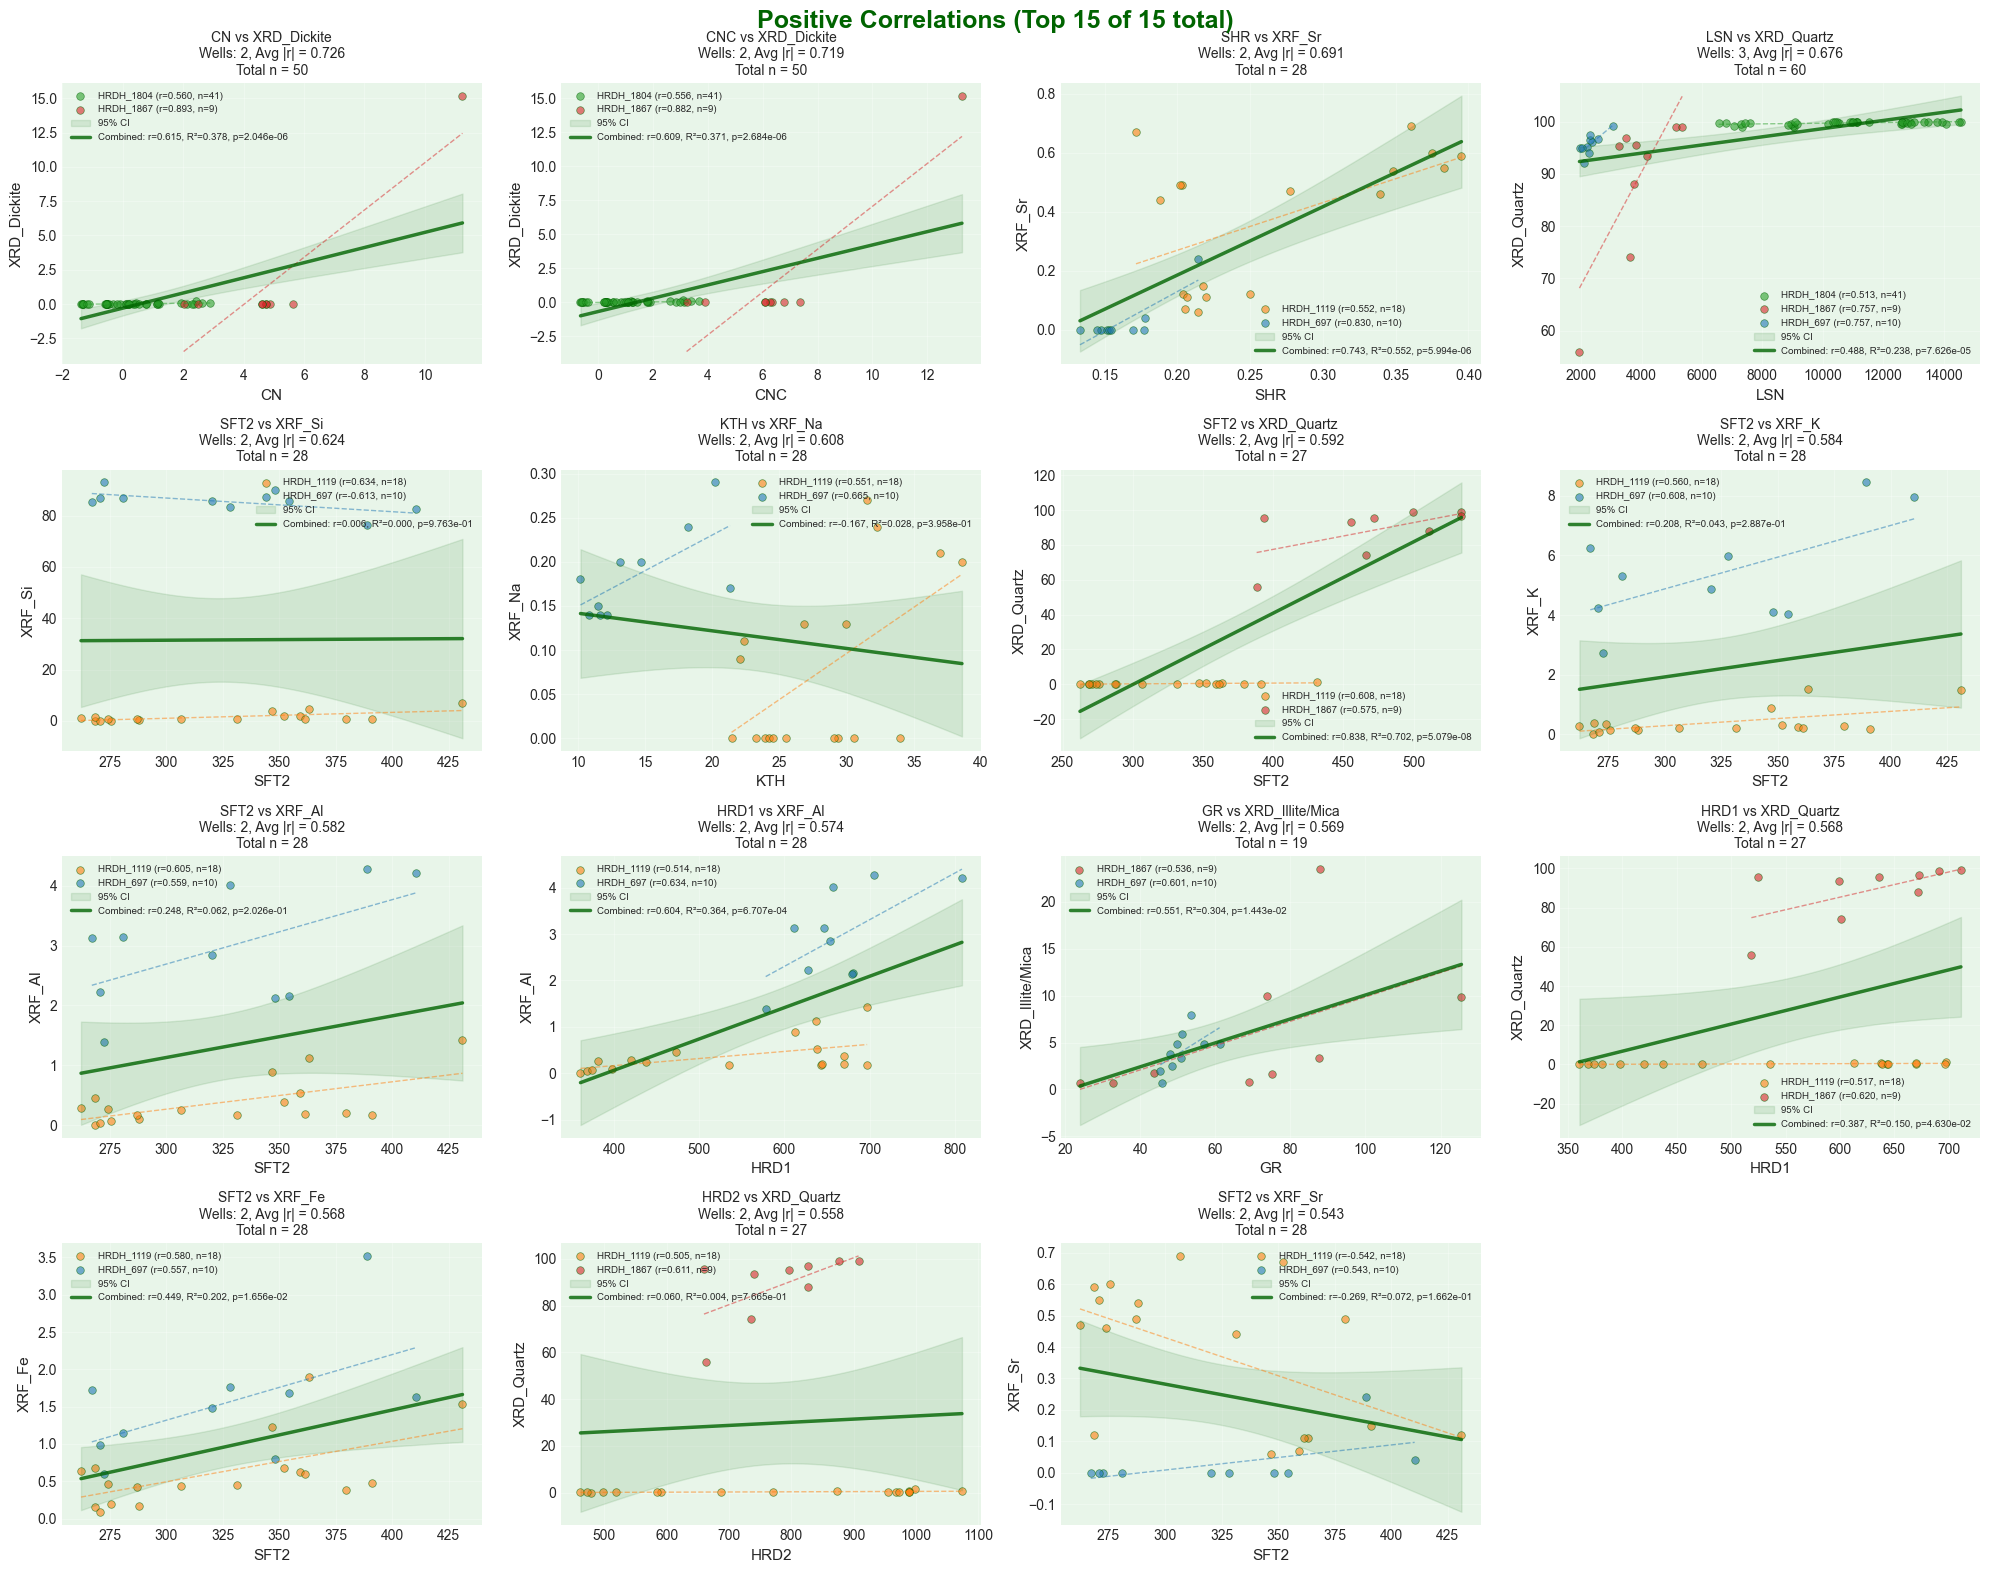

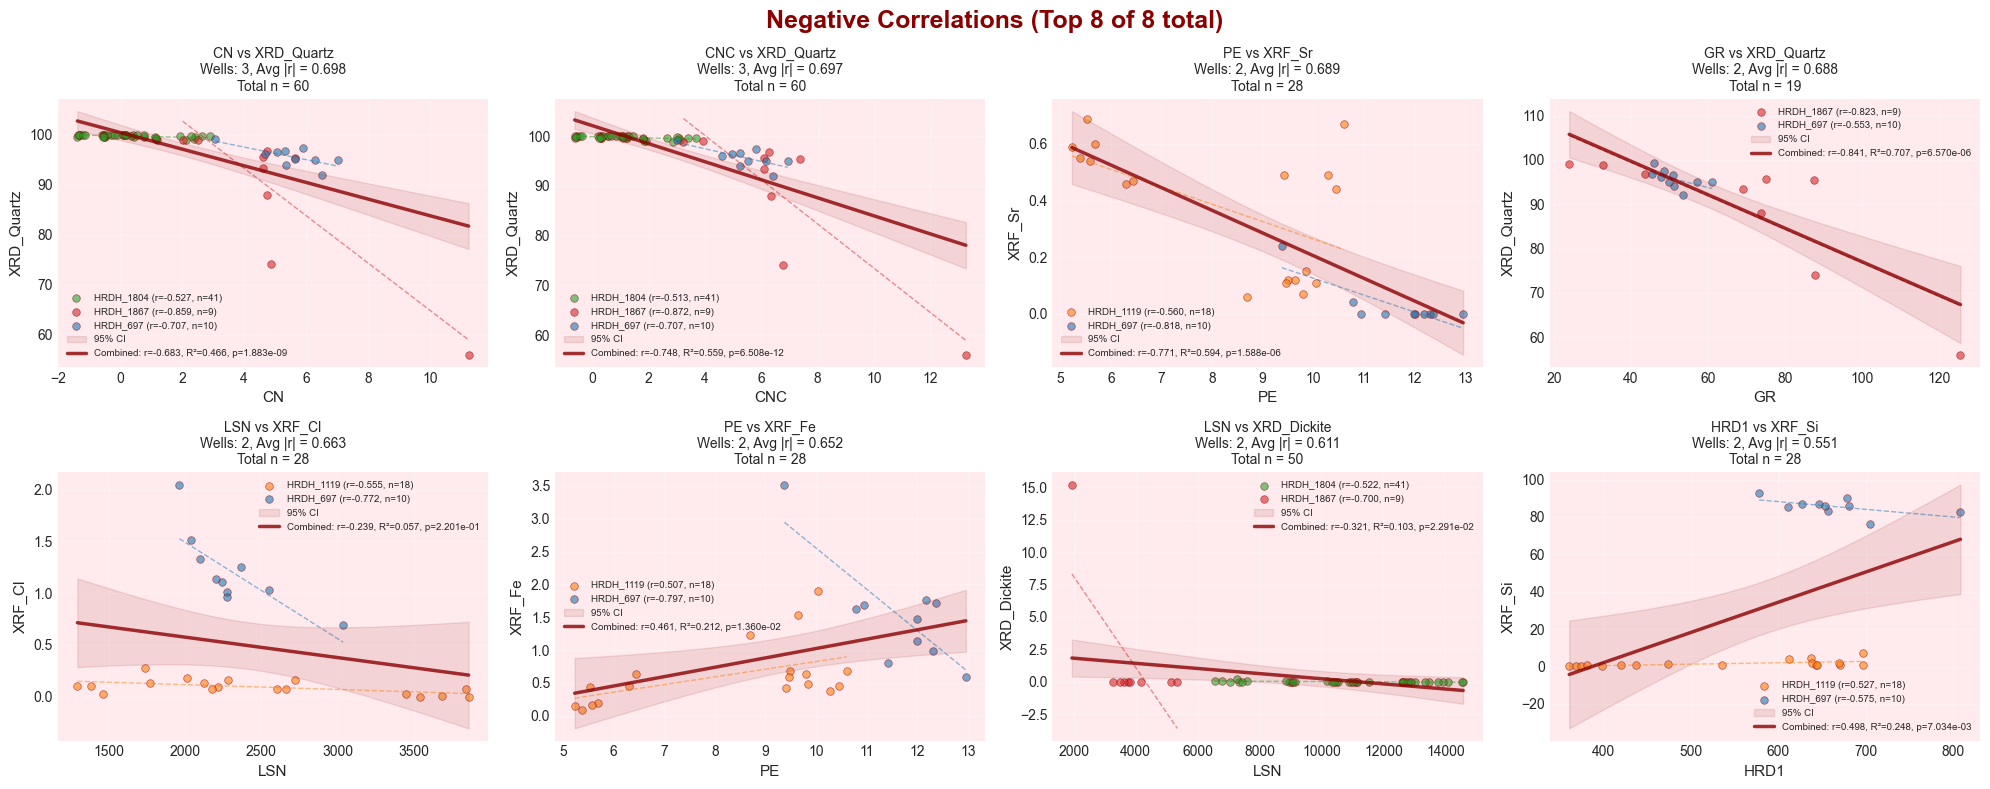


SCATTER PLOT GENERATION SUMMARY

📊 COMBINED REGRESSION LINE EXPLANATION:
------------------------------------------------------------
The COMBINED regression line (thick solid line) represents:
• A linear fit through ALL data points from ALL wells combined
• The overall relationship across the entire dataset
• Combined r: Pearson correlation coefficient for all points
• R²: Coefficient of determination (explained variance)
• p-value: Statistical significance of the correlation
• 95% CI: Confidence interval for the regression line

Individual well regression lines (thin dashed) show:
• The specific relationship within each well
• How each well's trend compares to the combined trend

📈 CORRELATION SUMMARY:
Total positive correlations: 15
Total negative correlations: 8
Total correlations visualized: 23

3 wells: 3 total (1 positive, 2 negative)

2 wells: 20 total (14 positive, 6 negative)

🔝 Top 5 Positive Correlations:
1. CN vs XRD_Dickite: |r̄| = 0.726 (2 wells)
2. CNC vs XRD_Dickite: 

In [19]:

def create_comprehensive_correlation_scatter_plots(df_all, correlations_by_well_count, max_plots_per_figure=20):
    """
    Create two comprehensive scatter plot figures: one for positive and one for negative correlations.
    Plots are sorted by correlation strength and include combined statistics.
    
    The combined regression line represents the overall linear relationship across ALL data points
    from ALL wells combined, not just an average of individual well correlations.
    """
    
    # Define colors for each well
    well_colors = {
        'HRDH_697': '#1f77b4',
        'HRDH_1119': '#ff7f0e', 
        'HRDH_1804': '#2ca02c',
        'HRDH_1867': '#d62728'
    }
    
    # Collect all correlations from all well counts
    all_positive_corrs = []
    all_negative_corrs = []
    
    for n_wells in correlations_by_well_count.keys():
        correlations = correlations_by_well_count[n_wells]
        
        for pair, wells_data, info in correlations:
            if info['correlation_type'] == 'positive':
                all_positive_corrs.append((pair, wells_data, info))
            else:
                all_negative_corrs.append((pair, wells_data, info))
    
    # Sort by average absolute correlation (highest first)
    all_positive_corrs.sort(key=lambda x: x[2]['avg_abs_corr'], reverse=True)
    all_negative_corrs.sort(key=lambda x: x[2]['avg_abs_corr'], reverse=True)
    
    # Create figure for positive correlations
    if all_positive_corrs:
        n_positive = min(len(all_positive_corrs), max_plots_per_figure)
        n_cols = 4
        n_rows = (n_positive + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
        if n_positive == 1:
            axes = [axes]
        else:
            axes = axes.flatten() if n_rows > 1 or n_cols > 1 else [axes]
        
        fig.suptitle(f'Positive Correlations (Top {n_positive} of {len(all_positive_corrs)} total)', 
                    fontsize=18, fontweight='bold', color='darkgreen')
        
        for idx, (pair, wells_data, info) in enumerate(all_positive_corrs[:n_positive]):
            ax = axes[idx]
            log_var, lab_var = pair
            
            # Collect all data points for combined analysis
            all_x = []
            all_y = []
            
            # Plot data for each well with individual regression lines
            for well, r in wells_data:
                well_data = df_all[df_all['Well'] == well]
                
                # Get valid data points
                mask = (~well_data[log_var].isna()) & (~well_data[lab_var].isna())
                x_data = well_data.loc[mask, log_var].values
                y_data = well_data.loc[mask, lab_var].values
                
                if len(x_data) > 0:
                    ax.scatter(x_data, y_data, 
                             color=well_colors[well], 
                             alpha=0.6, 
                             s=30,
                             label=f'{well} (r={r:.3f}, n={len(x_data)})',
                             edgecolors='darkgreen',
                             linewidth=0.5)
                    
                    # Add individual well regression line (thinner, dashed)
                    if len(x_data) > 1:
                        z_well = np.polyfit(x_data, y_data, 1)
                        p_well = np.poly1d(z_well)
                        x_line_well = np.linspace(x_data.min(), x_data.max(), 50)
                        ax.plot(x_line_well, p_well(x_line_well), 
                               color=well_colors[well], 
                               linestyle='--', 
                               alpha=0.5, 
                               linewidth=1)
                    
                    all_x.extend(x_data)
                    all_y.extend(y_data)
            
            # Calculate combined statistics from ALL data points
            if len(all_x) > 3:
                all_x = np.array(all_x)
                all_y = np.array(all_y)
                
                # Combined correlation coefficient (Pearson's r)
                combined_r, combined_p = stats.pearsonr(all_x, all_y)
                
                # Calculate R-squared
                z = np.polyfit(all_x, all_y, 1)
                p = np.poly1d(z)
                y_pred = p(all_x)
                ss_res = np.sum((all_y - y_pred)**2)
                ss_tot = np.sum((all_y - np.mean(all_y))**2)
                r_squared = 1 - (ss_res / ss_tot)
                
                # Calculate 95% confidence interval for the regression line
                n = len(all_x)
                t_val = stats.t.ppf(0.975, n-2)  # 95% CI
                s_yx = np.sqrt(ss_res / (n-2))  # Standard error of estimate
                
                x_line = np.linspace(all_x.min(), all_x.max(), 100)
                y_line = p(x_line)
                
                # Standard error for each predicted value
                x_mean = np.mean(all_x)
                se_line = s_yx * np.sqrt(1/n + (x_line - x_mean)**2 / np.sum((all_x - x_mean)**2))
                ci_upper = y_line + t_val * se_line
                ci_lower = y_line - t_val * se_line
                
                # Plot confidence interval
                ax.fill_between(x_line, ci_lower, ci_upper, 
                               color='darkgreen', alpha=0.1, 
                               label='95% CI')
                
                # Plot combined regression line
                ax.plot(x_line, y_line, color='darkgreen', 
                       linestyle='-', alpha=0.8, linewidth=2.5,
                       label=f'Combined: r={combined_r:.3f}, R²={r_squared:.3f}, p={combined_p:.3e}')
            
            # Shade background green for positive correlation
            ax.set_facecolor('#e8f5e9')
            
            # Formatting
            ax.set_xlabel(log_var.replace('Log_', ''), fontsize=11)
            ax.set_ylabel(lab_var.replace('Lab_', ''), fontsize=11)
            ax.set_title(f"{log_var.replace('Log_', '')} vs {lab_var.replace('Lab_', '')}\n" + 
                        f"Wells: {info['n_wells']}, Avg |r| = {info['avg_abs_corr']:.3f}\n" +
                        f"Total n = {len(all_x)}", fontsize=10)
            ax.legend(fontsize=7, loc='best', framealpha=0.9)
            ax.grid(True, alpha=0.3)
        
        # Hide empty subplots
        for idx in range(n_positive, len(axes)):
            axes[idx].set_visible(False)
        
        plt.tight_layout()
        plt.savefig('imgs/scatter_all_positive_correlations.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    # Create figure for negative correlations
    if all_negative_corrs:
        n_negative = min(len(all_negative_corrs), max_plots_per_figure)
        n_cols = 4
        n_rows = (n_negative + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
        if n_negative == 1:
            axes = [axes]
        else:
            axes = axes.flatten() if n_rows > 1 or n_cols > 1 else [axes]
        
        fig.suptitle(f'Negative Correlations (Top {n_negative} of {len(all_negative_corrs)} total)', 
                    fontsize=18, fontweight='bold', color='darkred')
        
        for idx, (pair, wells_data, info) in enumerate(all_negative_corrs[:n_negative]):
            ax = axes[idx]
            log_var, lab_var = pair
            
            # Collect all data points for combined analysis
            all_x = []
            all_y = []
            
            # Plot data for each well with individual regression lines
            for well, r in wells_data:
                well_data = df_all[df_all['Well'] == well]
                
                # Get valid data points
                mask = (~well_data[log_var].isna()) & (~well_data[lab_var].isna())
                x_data = well_data.loc[mask, log_var].values
                y_data = well_data.loc[mask, lab_var].values
                
                if len(x_data) > 0:
                    ax.scatter(x_data, y_data, 
                             color=well_colors[well], 
                             alpha=0.6, 
                             s=30,
                             label=f'{well} (r={r:.3f}, n={len(x_data)})',
                             edgecolors='darkred',
                             linewidth=0.5)
                    
                    # Add individual well regression line (thinner, dashed)
                    if len(x_data) > 1:
                        z_well = np.polyfit(x_data, y_data, 1)
                        p_well = np.poly1d(z_well)
                        x_line_well = np.linspace(x_data.min(), x_data.max(), 50)
                        ax.plot(x_line_well, p_well(x_line_well), 
                               color=well_colors[well], 
                               linestyle='--', 
                               alpha=0.5, 
                               linewidth=1)
                    
                    all_x.extend(x_data)
                    all_y.extend(y_data)
            
            # Calculate combined statistics from ALL data points
            if len(all_x) > 3:
                all_x = np.array(all_x)
                all_y = np.array(all_y)
                
                # Combined correlation coefficient (Pearson's r)
                combined_r, combined_p = stats.pearsonr(all_x, all_y)
                
                # Calculate R-squared
                z = np.polyfit(all_x, all_y, 1)
                p = np.poly1d(z)
                y_pred = p(all_x)
                ss_res = np.sum((all_y - y_pred)**2)
                ss_tot = np.sum((all_y - np.mean(all_y))**2)
                r_squared = 1 - (ss_res / ss_tot)
                
                # Calculate 95% confidence interval for the regression line
                n = len(all_x)
                t_val = stats.t.ppf(0.975, n-2)  # 95% CI
                s_yx = np.sqrt(ss_res / (n-2))  # Standard error of estimate
                
                x_line = np.linspace(all_x.min(), all_x.max(), 100)
                y_line = p(x_line)
                
                # Standard error for each predicted value
                x_mean = np.mean(all_x)
                se_line = s_yx * np.sqrt(1/n + (x_line - x_mean)**2 / np.sum((all_x - x_mean)**2))
                ci_upper = y_line + t_val * se_line
                ci_lower = y_line - t_val * se_line
                
                # Plot confidence interval
                ax.fill_between(x_line, ci_lower, ci_upper, 
                               color='darkred', alpha=0.1, 
                               label='95% CI')
                
                # Plot combined regression line
                ax.plot(x_line, y_line, color='darkred', 
                       linestyle='-', alpha=0.8, linewidth=2.5,
                       label=f'Combined: r={combined_r:.3f}, R²={r_squared:.3f}, p={combined_p:.3e}')
            
            # Shade background red for negative correlation
            ax.set_facecolor('#ffebee')
            
            # Formatting
            ax.set_xlabel(log_var.replace('Log_', ''), fontsize=11)
            ax.set_ylabel(lab_var.replace('Lab_', ''), fontsize=11)
            ax.set_title(f"{log_var.replace('Log_', '')} vs {lab_var.replace('Lab_', '')}\n" + 
                        f"Wells: {info['n_wells']}, Avg |r| = {info['avg_abs_corr']:.3f}\n" +
                        f"Total n = {len(all_x)}", fontsize=10)
            ax.legend(fontsize=7, loc='best', framealpha=0.9)
            ax.grid(True, alpha=0.3)
        
        # Hide empty subplots
        for idx in range(n_negative, len(axes)):
            axes[idx].set_visible(False)
        
        plt.tight_layout()
        plt.savefig('imgs/scatter_all_negative_correlations.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    # Create summary statistics with explanation
    print("\n" + "="*80)
    print("SCATTER PLOT GENERATION SUMMARY")
    print("="*80)
    
    print("\n📊 COMBINED REGRESSION LINE EXPLANATION:")
    print("-" * 60)
    print("The COMBINED regression line (thick solid line) represents:")
    print("• A linear fit through ALL data points from ALL wells combined")
    print("• The overall relationship across the entire dataset")
    print("• Combined r: Pearson correlation coefficient for all points")
    print("• R²: Coefficient of determination (explained variance)")
    print("• p-value: Statistical significance of the correlation")
    print("• 95% CI: Confidence interval for the regression line")
    print("\nIndividual well regression lines (thin dashed) show:")
    print("• The specific relationship within each well")
    print("• How each well's trend compares to the combined trend")
    
    print(f"\n📈 CORRELATION SUMMARY:")
    print(f"Total positive correlations: {len(all_positive_corrs)}")
    print(f"Total negative correlations: {len(all_negative_corrs)}")
    print(f"Total correlations visualized: {min(len(all_positive_corrs), max_plots_per_figure) + min(len(all_negative_corrs), max_plots_per_figure)}")
    
    # Distribution by well count
    for n_wells in sorted(correlations_by_well_count.keys(), reverse=True):
        corrs = correlations_by_well_count[n_wells]
        if corrs:
            pos_count = sum(1 for _, _, info in corrs if info['correlation_type'] == 'positive')
            neg_count = sum(1 for _, _, info in corrs if info['correlation_type'] == 'negative')
            print(f"\n{n_wells} wells: {len(corrs)} total ({pos_count} positive, {neg_count} negative)")
    
    # Top correlations summary
    print("\n🔝 Top 5 Positive Correlations:")
    for i, (pair, wells_data, info) in enumerate(all_positive_corrs[:5]):
        log_var, lab_var = pair
        print(f"{i+1}. {log_var.replace('Log_', '')} vs {lab_var.replace('Lab_', '')}: " +
              f"|r̄| = {info['avg_abs_corr']:.3f} ({info['n_wells']} wells)")
    
    print("\n🔝 Top 5 Negative Correlations:")
    for i, (pair, wells_data, info) in enumerate(all_negative_corrs[:5]):
        log_var, lab_var = pair
        print(f"{i+1}. {log_var.replace('Log_', '')} vs {lab_var.replace('Lab_', '')}: " +
              f"|r̄| = {info['avg_abs_corr']:.3f} ({info['n_wells']} wells)")


# Call the function to create scatter plots
print("Creating comprehensive scatter plots for common correlations...")
create_comprehensive_correlation_scatter_plots(df_all, correlations_by_well_count, max_plots_per_figure=20)

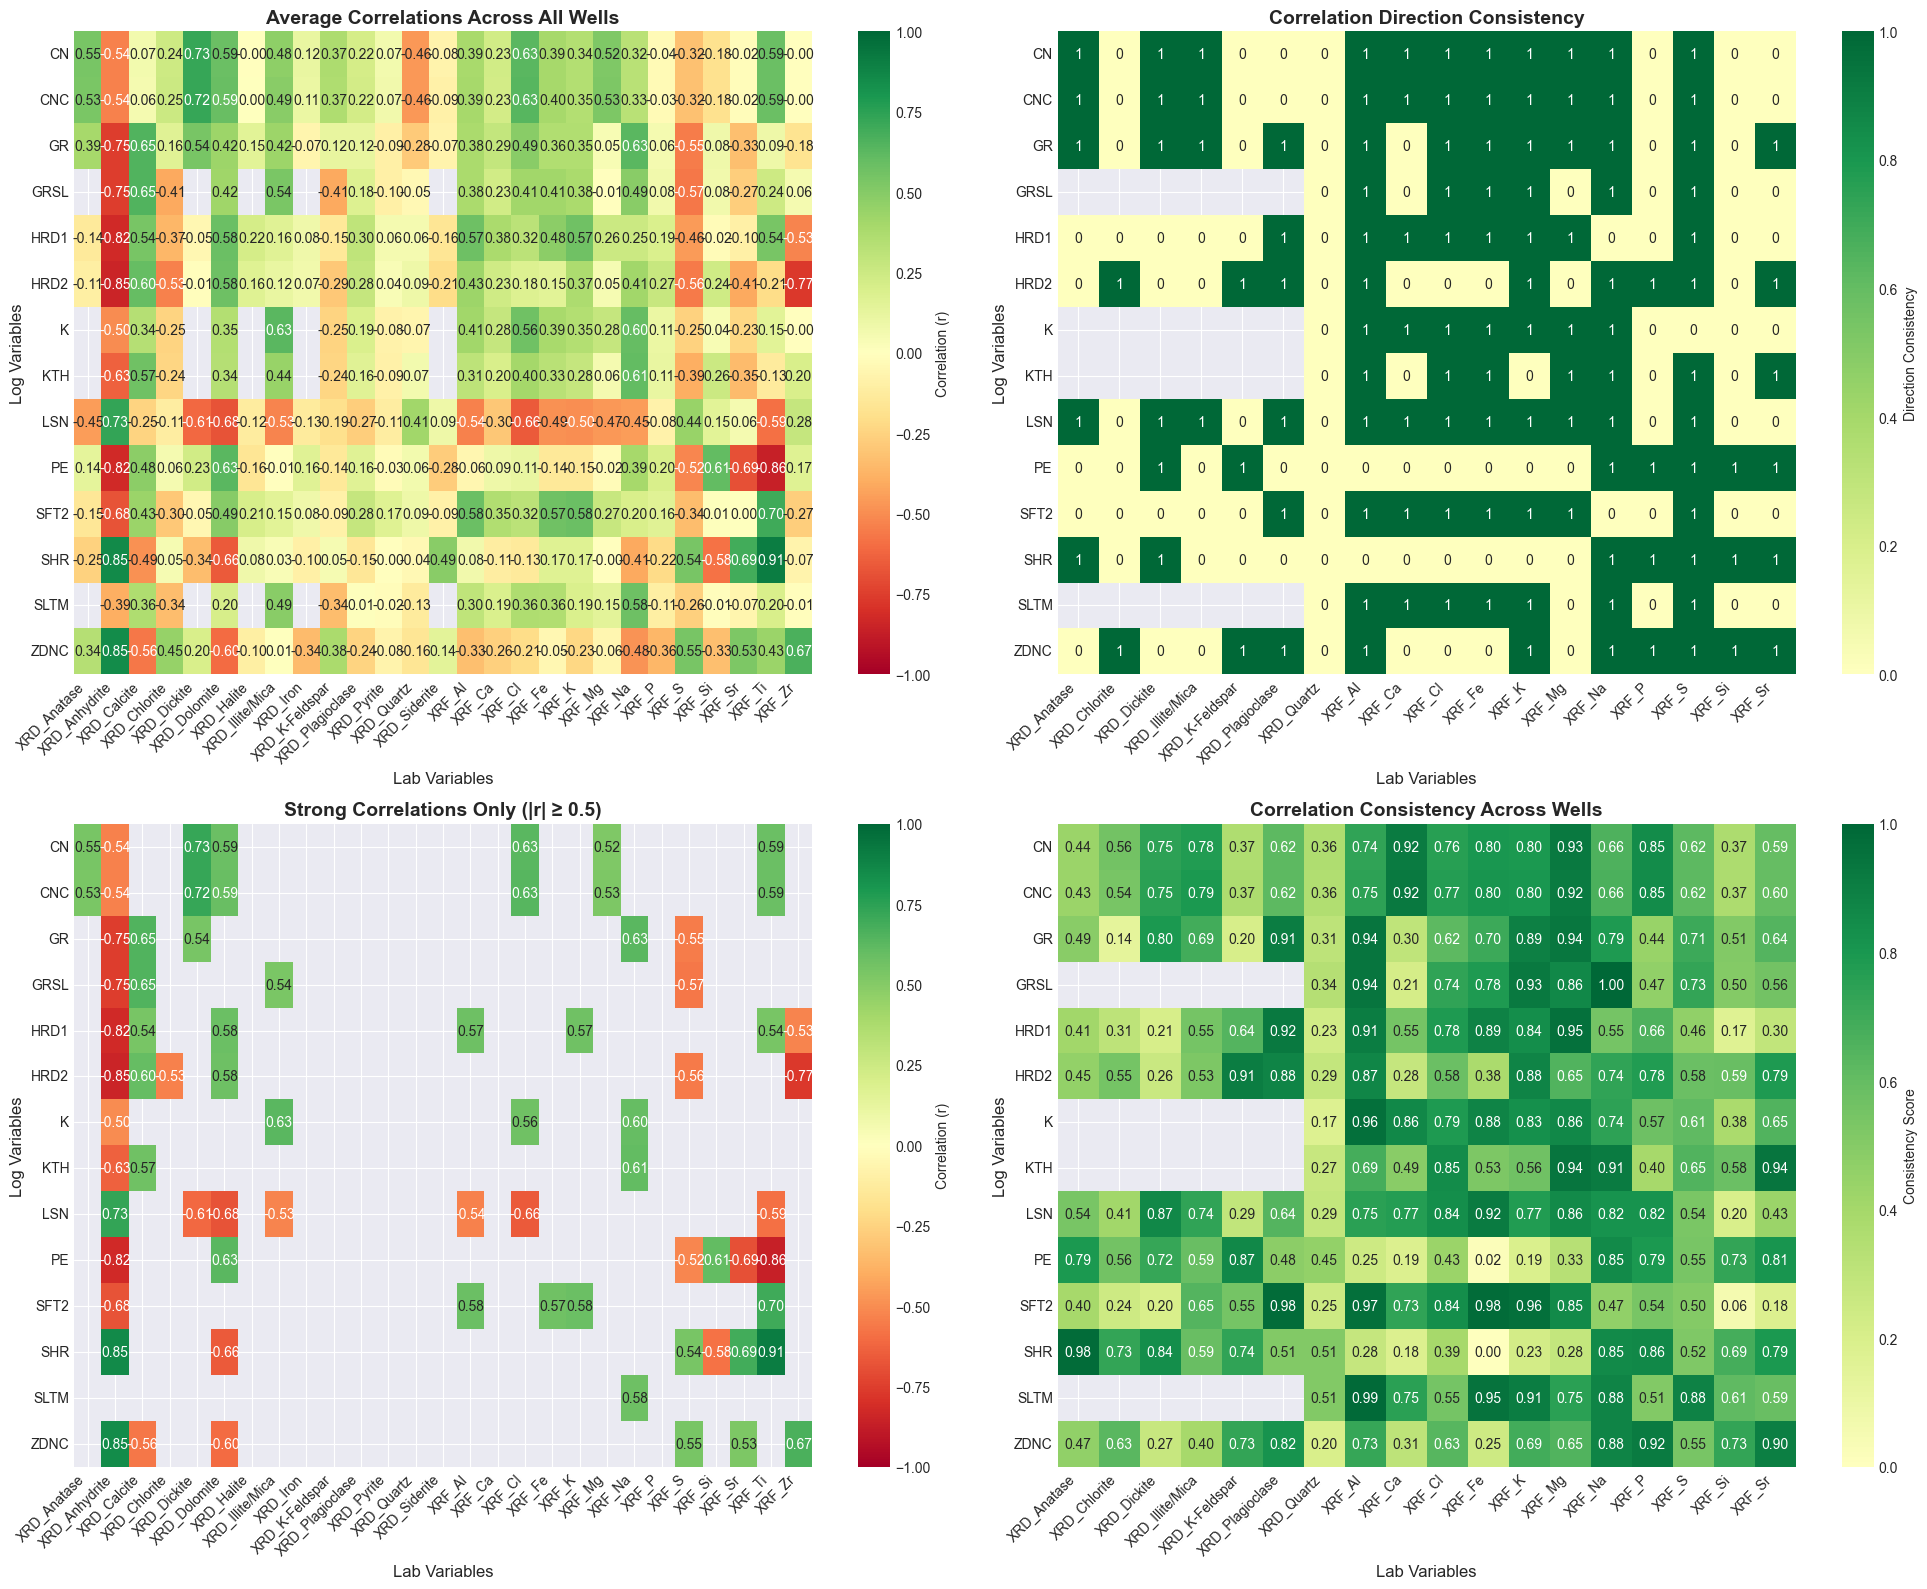


Creating individual well correlation heatmaps...


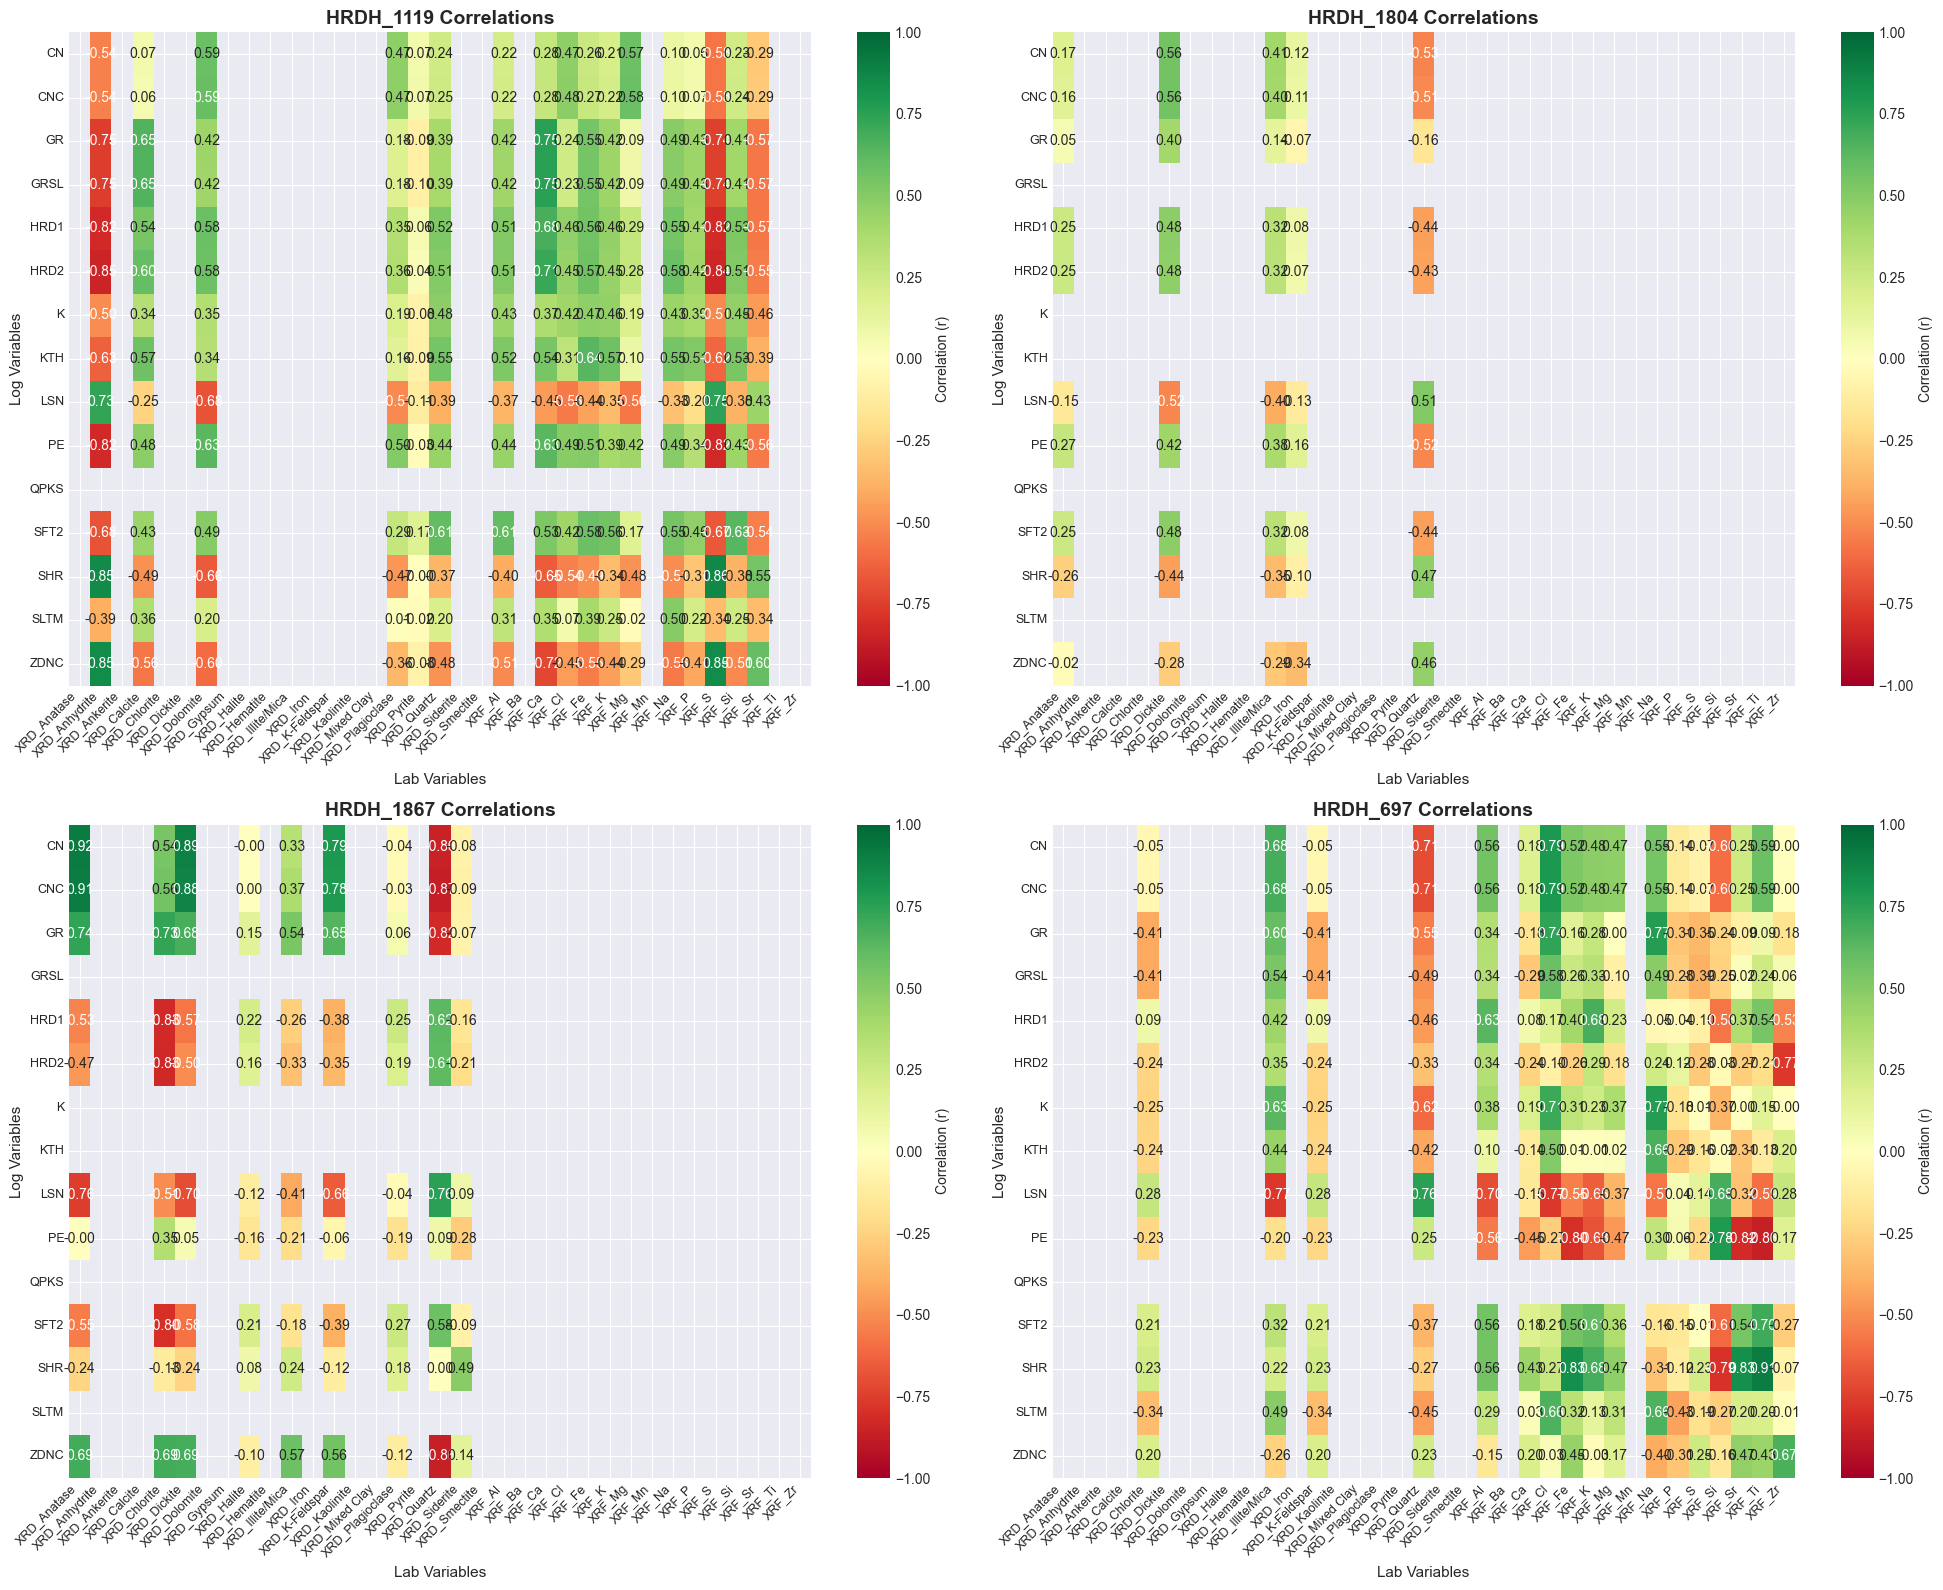


Creating top correlations comparison heatmap...


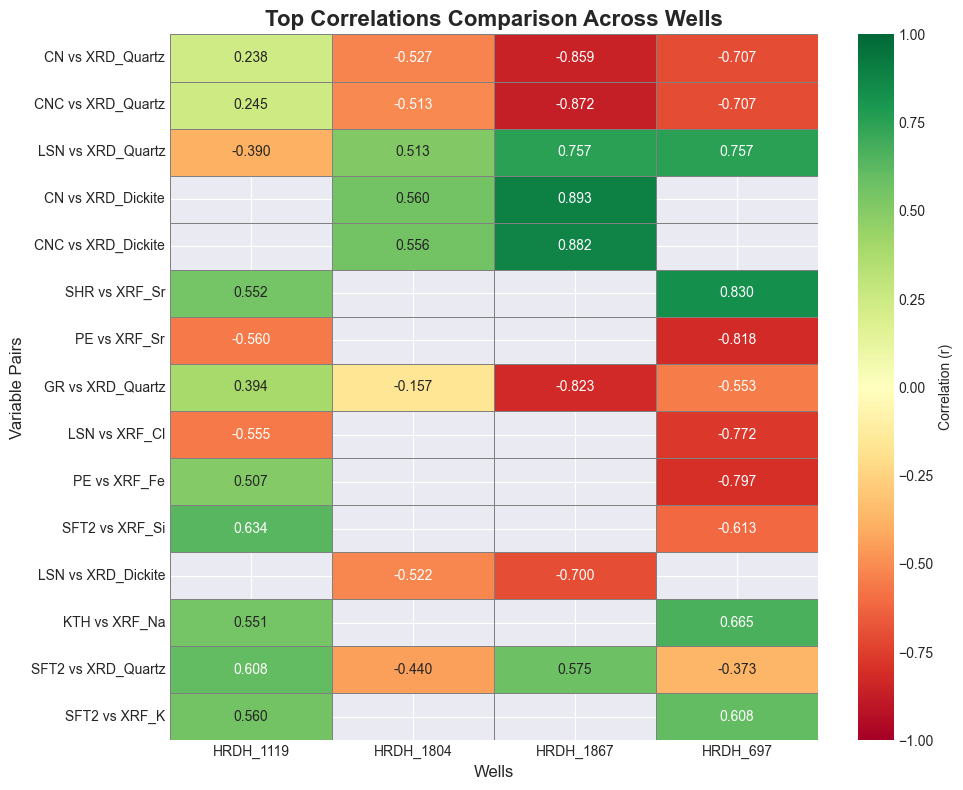


✅ All correlation heatmaps created successfully!
   Saved to: imgs/


In [20]:
def create_correlation_heatmaps(well_correlations, common_correlations, df_all, lab_columns, log_columns):
    """Create comprehensive correlation heatmaps using RdYlGn colormap."""
    
    def create_heatmap(data, ax, title, cmap='RdYlGn', center=0, vmin=-1, vmax=1, 
                       fmt='.2f', cbar_label='Correlation (r)'):
        """Helper function to create a standardized heatmap."""
        sns.heatmap(data.astype(float), 
                    annot=True, fmt=fmt, 
                    cmap=cmap, 
                    center=center, vmin=vmin, vmax=vmax,
                    cbar_kws={'label': cbar_label},
                    ax=ax)
        ax.set_title(title, fontsize=14, fontweight='bold')
        ax.set_xlabel('Lab Variables', fontsize=12)
        ax.set_ylabel('Log Variables', fontsize=12)
        ax.set_xticklabels([col.replace('Lab_', '') for col in data.columns], rotation=45, ha='right')
        ax.set_yticklabels([row.replace('Log_', '') for row in data.index], rotation=0)
        return ax
    
    # Calculate average correlations
    avg_corr_matrix = pd.DataFrame(index=log_columns, columns=lab_columns, dtype=float)
    count_matrix = pd.DataFrame(index=log_columns, columns=lab_columns, dtype=int)
    
    for well, corr_matrix in well_correlations.items():
        for log_var in log_columns:
            for lab_var in lab_columns:
                if log_var in corr_matrix.index and lab_var in corr_matrix.columns:
                    r = corr_matrix.loc[log_var, lab_var]
                    if not pd.isna(r):
                        if pd.isna(avg_corr_matrix.loc[log_var, lab_var]):
                            avg_corr_matrix.loc[log_var, lab_var] = 0
                            count_matrix.loc[log_var, lab_var] = 0
                        avg_corr_matrix.loc[log_var, lab_var] += r
                        count_matrix.loc[log_var, lab_var] += 1
    
    # Calculate averages
    avg_corr_matrix = avg_corr_matrix / count_matrix
    avg_corr_matrix = avg_corr_matrix.dropna(how='all', axis=0).dropna(how='all', axis=1)
    
    # Create main figure
    fig = plt.figure(figsize=(20, 16))
    
    # Plot 1: Average correlations
    ax1 = plt.subplot(2, 2, 1)
    create_heatmap(avg_corr_matrix, ax1, 'Average Correlations Across All Wells')
    
    # Plot 2: Correlation direction consistency
    ax2 = plt.subplot(2, 2, 2)
    direction_matrix = pd.DataFrame(index=log_columns, columns=lab_columns, dtype=float)
    
    for log_var in log_columns:
        for lab_var in lab_columns:
            well_corrs = [well_correlations[well].loc[log_var, lab_var] 
                         for well in well_correlations 
                         if log_var in well_correlations[well].index 
                         and lab_var in well_correlations[well].columns 
                         and not pd.isna(well_correlations[well].loc[log_var, lab_var])]
            if len(well_corrs) >= 2:
                # Check if all correlations have the same sign
                positive_count = sum(1 for r in well_corrs if r > 0)
                negative_count = sum(1 for r in well_corrs if r < 0)
                total_count = len(well_corrs)
                
                # Direction consistency score: 1 if all same sign, 0 if mixed
                if positive_count == total_count or negative_count == total_count:
                    direction_matrix.loc[log_var, lab_var] = 1.0
                else:
                    direction_matrix.loc[log_var, lab_var] = 0.0
    
    direction_matrix = direction_matrix.dropna(how='all', axis=0).dropna(how='all', axis=1)
    create_heatmap(direction_matrix, ax2, 'Correlation Direction Consistency',
                   cmap='RdYlGn', vmin=0, vmax=1, fmt='.0f', cbar_label='Direction Consistency')
    
    # Plot 3: Strong correlations only
    ax3 = plt.subplot(2, 2, 3)
    strong_corr = avg_corr_matrix.where(np.abs(avg_corr_matrix) >= 0.5)
    create_heatmap(strong_corr, ax3, 'Strong Correlations Only (|r| ≥ 0.5)')
    
    # Plot 4: Consistency score
    ax4 = plt.subplot(2, 2, 4)
    std_matrix = pd.DataFrame(index=log_columns, columns=lab_columns, dtype=float)
    
    for log_var in log_columns:
        for lab_var in lab_columns:
            well_corrs = [well_correlations[well].loc[log_var, lab_var] 
                         for well in well_correlations 
                         if log_var in well_correlations[well].index 
                         and lab_var in well_correlations[well].columns 
                         and not pd.isna(well_correlations[well].loc[log_var, lab_var])]
            if len(well_corrs) >= 2:
                std_matrix.loc[log_var, lab_var] = np.std(well_corrs)
    
    std_matrix = std_matrix.dropna(how='all', axis=0).dropna(how='all', axis=1)
    consistency_matrix = 1 - (std_matrix / std_matrix.max().max())
    create_heatmap(consistency_matrix, ax4, 'Correlation Consistency Across Wells',
                   vmin=0, vmax=1, cbar_label='Consistency Score')
    
    plt.tight_layout()
    plt.savefig('imgs/correlation_heatmaps_comprehensive.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Individual well heatmaps
    print("\nCreating individual well correlation heatmaps...")
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    axes = axes.flatten()
    
    for idx, (well, corr_matrix) in enumerate(well_correlations.items()):
        ax = axes[idx]
        valid_log_cols = [col for col in log_columns if col in corr_matrix.index]
        valid_lab_cols = [col for col in lab_columns if col in corr_matrix.columns]
        
        if valid_log_cols and valid_lab_cols:
            well_corr_subset = corr_matrix.loc[valid_log_cols, valid_lab_cols]
            sns.heatmap(well_corr_subset.astype(float), 
                       annot=True, fmt='.2f', 
                       cmap='RdYlGn', 
                       center=0, vmin=-1, vmax=1,
                       cbar_kws={'label': 'Correlation (r)'},
                       ax=ax)
            ax.set_title(f'{well} Correlations', fontsize=14, fontweight='bold')
            ax.set_xlabel('Lab Variables', fontsize=11)
            ax.set_ylabel('Log Variables', fontsize=11)
            ax.set_xticklabels([col.replace('Lab_', '') for col in well_corr_subset.columns], 
                              rotation=45, ha='right', fontsize=9)
            ax.set_yticklabels([row.replace('Log_', '') for row in well_corr_subset.index], 
                              rotation=0, fontsize=9)
    
    plt.tight_layout()
    plt.savefig('imgs/correlation_heatmaps_by_well.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Top correlations comparison heatmap
    if common_correlations:
        print("\nCreating top correlations comparison heatmap...")
        top_n = min(15, len(common_correlations))
        wells = sorted(df_all['Well'].unique())
        comparison_matrix = []
        top_pairs = []
        
        for i, item in enumerate(common_correlations[:top_n]):
            if len(item) == 3:
                pair, wells_data, _ = item
            else:
                pair, wells_data = item
            
            log_var, lab_var = pair
            pair_label = f"{log_var.replace('Log_', '')} vs {lab_var.replace('Lab_', '')}"
            top_pairs.append(pair_label)
            
            wells_with_corr = {w: r for w, r in wells_data}
            row = []
            
            for well in wells:
                if well in wells_with_corr:
                    row.append(wells_with_corr[well])
                elif well in well_correlations and log_var in well_correlations[well].index and lab_var in well_correlations[well].columns:
                    r = well_correlations[well].loc[log_var, lab_var]
                    row.append(r if not pd.isna(r) else np.nan)
                else:
                    row.append(np.nan)
            
            comparison_matrix.append(row)
        
        comparison_df = pd.DataFrame(comparison_matrix, index=top_pairs, columns=wells)
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(comparison_df.astype(float), 
                    annot=True, fmt='.3f', 
                    cmap='RdYlGn', 
                    center=0, vmin=-1, vmax=1,
                    cbar_kws={'label': 'Correlation (r)'},
                    linewidths=0.5,
                    linecolor='gray')
        plt.title('Top Correlations Comparison Across Wells', fontsize=16, fontweight='bold')
        plt.xlabel('Wells', fontsize=12)
        plt.ylabel('Variable Pairs', fontsize=12)
        plt.xticks(rotation=0)
        plt.yticks(rotation=0)
        
        plt.tight_layout()
        plt.savefig('imgs/top_correlations_comparison_heatmap.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    print("\n✅ All correlation heatmaps created successfully!")
    print("   Saved to: imgs/")

# Create the heatmaps
create_correlation_heatmaps(well_correlations, common_correlations, df_all, lab_columns, log_columns)

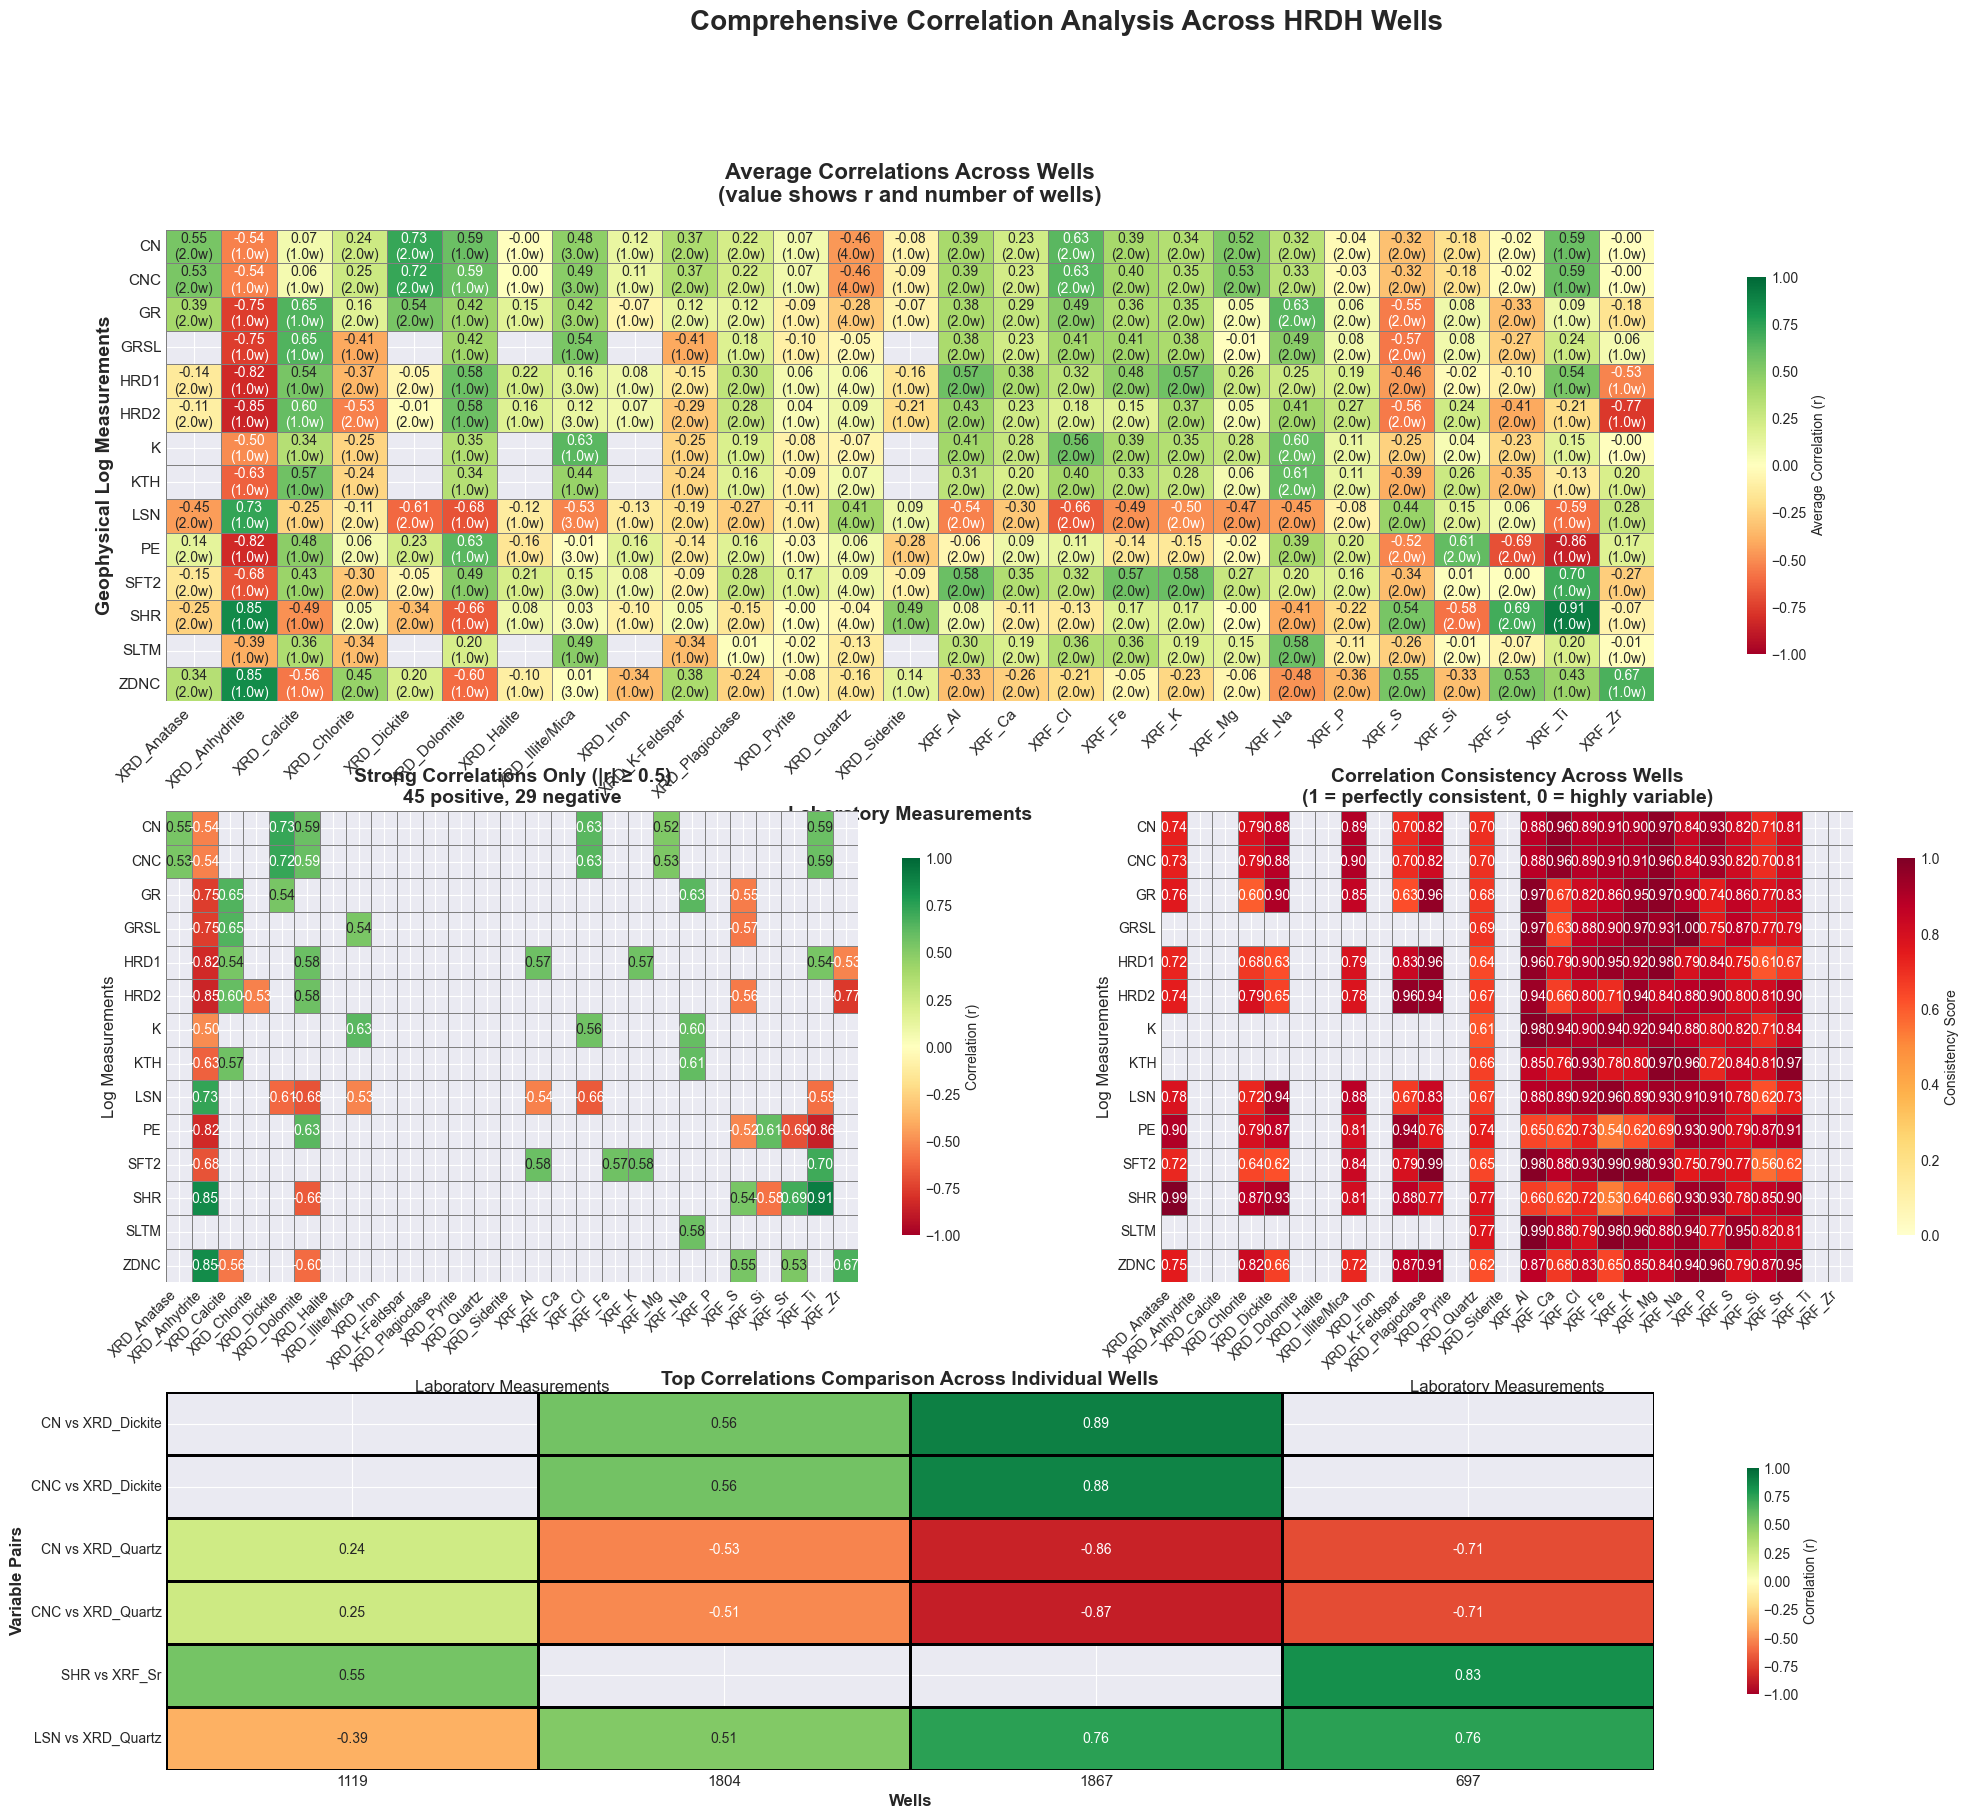


CORRELATION HEATMAP SUMMARY

Total correlation pairs analyzed: 358

Correlation strength distribution:
  Very strong (|r| ≥ 0.7): 13 (3.6%)
  Strong (0.5 ≤ |r| < 0.7): 61 (17.0%)
  Moderate (0.3 ≤ |r| < 0.5): 89 (24.9%)
  Weak (|r| < 0.3): 195 (54.5%)

Consistency analysis (for pairs in ≥2 wells):
  High consistency (score ≥ 0.8): 135
  Good consistency (0.6 ≤ score < 0.8): 89

Most consistent strong correlations:
  1. LSN vs XRD_Illite/Mica: r=-0.527, consistency=0.88, wells=3.0
  2. CN vs XRD_Dickite: r=0.726, consistency=0.88, wells=2.0
  3. CNC vs XRD_Dickite: r=0.719, consistency=0.88, wells=2.0
  4. SHR vs XRF_Sr: r=0.691, consistency=0.90, wells=2.0
  5. PE vs XRF_Sr: r=-0.689, consistency=0.91, wells=2.0


In [23]:

def create_improved_correlation_heatmaps(well_correlations, correlations_by_well_count, df_all, lab_columns, log_columns):
    """
    Create improved correlation heatmaps focusing on the most informative visualizations:
    1. Average correlations across wells
    2. Strong correlations only (|r| ≥ 0.5)
    3. Correlation consistency across wells
    4. Well participation matrix showing which wells have data for each correlation pair
    """
    
    # Calculate average correlations and statistics
    avg_corr_matrix = pd.DataFrame(index=log_columns, columns=lab_columns, dtype=float)
    count_matrix = pd.DataFrame(index=log_columns, columns=lab_columns, dtype=int)
    std_matrix = pd.DataFrame(index=log_columns, columns=lab_columns, dtype=float)
    wells_present_matrix = pd.DataFrame(index=log_columns, columns=lab_columns, dtype=object)
    
    # Calculate statistics for each variable pair
    for log_var in log_columns:
        for lab_var in lab_columns:
            well_corrs = []
            wells_with_data = []
            
            for well, corr_matrix in well_correlations.items():
                if log_var in corr_matrix.index and lab_var in corr_matrix.columns:
                    r = corr_matrix.loc[log_var, lab_var]
                    if not pd.isna(r):
                        well_corrs.append(r)
                        wells_with_data.append(well.replace('HRDH_', ''))
            
            if well_corrs:
                avg_corr_matrix.loc[log_var, lab_var] = np.mean(well_corrs)
                count_matrix.loc[log_var, lab_var] = len(well_corrs)
                std_matrix.loc[log_var, lab_var] = np.std(well_corrs) if len(well_corrs) > 1 else 0
                wells_present_matrix.loc[log_var, lab_var] = ', '.join(wells_with_data)
    
    # Drop empty rows and columns
    avg_corr_matrix = avg_corr_matrix.dropna(how='all', axis=0).dropna(how='all', axis=1)
    std_matrix = std_matrix.dropna(how='all', axis=0).dropna(how='all', axis=1)
    count_matrix = count_matrix.dropna(how='all', axis=0).dropna(how='all', axis=1)
    
    # Create figure with custom layout
    fig = plt.figure(figsize=(24, 20))
    gs = fig.add_gridspec(3, 2, height_ratios=[1, 1, 0.8], width_ratios=[1, 1], 
                         hspace=0.25, wspace=0.15)
    
    # --- Plot 1: Average Correlations with annotation showing number of wells ---
    ax1 = fig.add_subplot(gs[0, :])
    
    # Create annotation text showing number of wells for each correlation
    annot_text = np.empty_like(avg_corr_matrix, dtype=object)
    for i in range(len(avg_corr_matrix.index)):
        for j in range(len(avg_corr_matrix.columns)):
            log_var = avg_corr_matrix.index[i]
            lab_var = avg_corr_matrix.columns[j]
            if not pd.isna(avg_corr_matrix.iloc[i, j]):
                r_val = avg_corr_matrix.iloc[i, j]
                n_wells = count_matrix.loc[log_var, lab_var]
                annot_text[i, j] = f'{r_val:.2f}\n({n_wells}w)'
            else:
                annot_text[i, j] = ''
    
    sns.heatmap(avg_corr_matrix.astype(float), 
                annot=annot_text, fmt='', 
                cmap='RdYlGn', 
                center=0, vmin=-1, vmax=1,
                cbar_kws={'label': 'Average Correlation (r)', 'shrink': 0.8},
                linewidths=0.5,
                linecolor='gray',
                ax=ax1)
    
    ax1.set_title('Average Correlations Across Wells\n(value shows r and number of wells)', 
                  fontsize=16, fontweight='bold', pad=20)
    ax1.set_xlabel('Laboratory Measurements', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Geophysical Log Measurements', fontsize=14, fontweight='bold')
    ax1.set_xticklabels([col.replace('Lab_', '') for col in avg_corr_matrix.columns], 
                        rotation=45, ha='right', fontsize=11)
    ax1.set_yticklabels([row.replace('Log_', '') for row in avg_corr_matrix.index], 
                        rotation=0, fontsize=11)
    
    # --- Plot 2: Strong Correlations Only (|r| ≥ 0.5) ---
    ax2 = fig.add_subplot(gs[1, 0])
    
    # Mask weak correlations
    strong_mask = np.abs(avg_corr_matrix) < 0.5
    strong_corr = avg_corr_matrix.copy()
    
    # Count strong correlations
    n_strong_positive = ((strong_corr >= 0.5) & (~pd.isna(strong_corr))).sum().sum()
    n_strong_negative = ((strong_corr <= -0.5) & (~pd.isna(strong_corr))).sum().sum()
    
    sns.heatmap(strong_corr.astype(float), 
                mask=strong_mask,
                annot=True, fmt='.2f', 
                cmap='RdYlGn', 
                center=0, vmin=-1, vmax=1,
                cbar_kws={'label': 'Correlation (r)', 'shrink': 0.8},
                linewidths=0.5,
                linecolor='gray',
                ax=ax2)
    
    ax2.set_title(f'Strong Correlations Only (|r| ≥ 0.5)\n{n_strong_positive} positive, {n_strong_negative} negative', 
                  fontsize=14, fontweight='bold')
    ax2.set_xlabel('Laboratory Measurements', fontsize=12)
    ax2.set_ylabel('Log Measurements', fontsize=12)
    ax2.set_xticklabels([col.replace('Lab_', '') for col in strong_corr.columns], 
                        rotation=45, ha='right', fontsize=10)
    ax2.set_yticklabels([row.replace('Log_', '') for row in strong_corr.index], 
                        rotation=0, fontsize=10)
    
    # --- Plot 3: Correlation Consistency (1 - normalized std) ---
    ax3 = fig.add_subplot(gs[1, 1])
    
    # Calculate consistency score (1 - normalized standard deviation)
    # Only for pairs with at least 2 wells
    consistency_matrix = pd.DataFrame(index=std_matrix.index, columns=std_matrix.columns, dtype=float)
    
    for log_var in std_matrix.index:
        for lab_var in std_matrix.columns:
            if count_matrix.loc[log_var, lab_var] >= 2:
                # Normalize std by the theoretical maximum std for correlation values
                # Max std occurs when correlations are -1 and 1, which gives std = 1.414
                normalized_std = std_matrix.loc[log_var, lab_var] / 1.414
                consistency_matrix.loc[log_var, lab_var] = 1 - normalized_std
    
    sns.heatmap(consistency_matrix.astype(float), 
                annot=True, fmt='.2f', 
                cmap='YlOrRd', 
                vmin=0, vmax=1,
                cbar_kws={'label': 'Consistency Score', 'shrink': 0.8},
                linewidths=0.5,
                linecolor='gray',
                ax=ax3)
    
    ax3.set_title('Correlation Consistency Across Wells\n(1 = perfectly consistent, 0 = highly variable)', 
                  fontsize=14, fontweight='bold')
    ax3.set_xlabel('Laboratory Measurements', fontsize=12)
    ax3.set_ylabel('Log Measurements', fontsize=12)
    ax3.set_xticklabels([col.replace('Lab_', '') for col in consistency_matrix.columns], 
                        rotation=45, ha='right', fontsize=10)
    ax3.set_yticklabels([row.replace('Log_', '') for row in consistency_matrix.index], 
                        rotation=0, fontsize=10)
    
    # --- Plot 4: Top Correlations Across Wells Comparison ---
    ax4 = fig.add_subplot(gs[2, :])
    
    # Get top correlations from each well count category
    top_correlations = []
    for n_wells in sorted(correlations_by_well_count.keys(), reverse=True):
        if correlations_by_well_count[n_wells]:
            # Add top 3 from each category
            for item in correlations_by_well_count[n_wells][:3]:
                pair, wells_data, info = item
                if info['avg_abs_corr'] >= 0.5:  # Only include strong correlations
                    top_correlations.append((pair, wells_data, info))
    
    # Limit to top 12 overall
    top_correlations = sorted(top_correlations, key=lambda x: x[2]['avg_abs_corr'], reverse=True)[:12]
    
    if top_correlations:
        # Create comparison matrix
        wells = sorted(df_all['Well'].unique())
        comparison_matrix = []
        pair_labels = []
        
        for pair, wells_data, info in top_correlations:
            log_var, lab_var = pair
            pair_label = f"{log_var.replace('Log_', '')} vs {lab_var.replace('Lab_', '')}"
            pair_labels.append(pair_label)
            
            wells_with_corr = {w: r for w, r in wells_data}
            row = []
            
            for well in wells:
                if well in wells_with_corr:
                    row.append(wells_with_corr[well])
                else:
                    # Check if this well has the correlation but it's below threshold
                    if well in well_correlations and log_var in well_correlations[well].index and lab_var in well_correlations[well].columns:
                        r = well_correlations[well].loc[log_var, lab_var]
                        if not pd.isna(r):
                            row.append(r)
                        else:
                            row.append(np.nan)
                    else:
                        row.append(np.nan)
            
            comparison_matrix.append(row)
        
        comparison_df = pd.DataFrame(comparison_matrix, 
                                   index=pair_labels, 
                                   columns=[w.replace('HRDH_', '') for w in wells])
        
        # Create heatmap with custom colormap for better visibility
        sns.heatmap(comparison_df.astype(float), 
                    annot=True, fmt='.2f', 
                    cmap='RdYlGn', 
                    center=0, vmin=-1, vmax=1,
                    cbar_kws={'label': 'Correlation (r)', 'shrink': 0.6},
                    linewidths=1,
                    linecolor='black',
                    ax=ax4)
        
        ax4.set_title('Top Correlations Comparison Across Individual Wells', 
                     fontsize=14, fontweight='bold')
        ax4.set_xlabel('Wells', fontsize=12, fontweight='bold')
        ax4.set_ylabel('Variable Pairs', fontsize=12, fontweight='bold')
        ax4.set_xticklabels(ax4.get_xticklabels(), rotation=0, fontsize=11)
        ax4.set_yticklabels(ax4.get_yticklabels(), rotation=0, fontsize=10)
    
    # Add overall title
    fig.suptitle('Comprehensive Correlation Analysis Across HRDH Wells', 
                 fontsize=20, fontweight='bold', y=0.99)
    
    plt.tight_layout()
    plt.savefig('imgs/improved_correlation_heatmaps.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*80)
    print("CORRELATION HEATMAP SUMMARY")
    print("="*80)
    
    total_pairs = (~pd.isna(avg_corr_matrix)).sum().sum()
    print(f"\nTotal correlation pairs analyzed: {total_pairs}")
    
    # Count correlations by strength
    very_strong = (np.abs(avg_corr_matrix) >= 0.7).sum().sum()
    strong = ((np.abs(avg_corr_matrix) >= 0.5) & (np.abs(avg_corr_matrix) < 0.7)).sum().sum()
    moderate = ((np.abs(avg_corr_matrix) >= 0.3) & (np.abs(avg_corr_matrix) < 0.5)).sum().sum()
    weak = ((np.abs(avg_corr_matrix) < 0.3) & (~pd.isna(avg_corr_matrix))).sum().sum()
    
    print(f"\nCorrelation strength distribution:")
    print(f"  Very strong (|r| ≥ 0.7): {very_strong} ({very_strong/total_pairs*100:.1f}%)")
    print(f"  Strong (0.5 ≤ |r| < 0.7): {strong} ({strong/total_pairs*100:.1f}%)")
    print(f"  Moderate (0.3 ≤ |r| < 0.5): {moderate} ({moderate/total_pairs*100:.1f}%)")
    print(f"  Weak (|r| < 0.3): {weak} ({weak/total_pairs*100:.1f}%)")
    
    # Consistency analysis
    high_consistency = (consistency_matrix >= 0.8).sum().sum()
    good_consistency = ((consistency_matrix >= 0.6) & (consistency_matrix < 0.8)).sum().sum()
    
    print(f"\nConsistency analysis (for pairs in ≥2 wells):")
    print(f"  High consistency (score ≥ 0.8): {high_consistency}")
    print(f"  Good consistency (0.6 ≤ score < 0.8): {good_consistency}")
    
    # Most consistent strong correlations
    print(f"\nMost consistent strong correlations:")
    strong_and_consistent = []
    for log_var in avg_corr_matrix.index:
        for lab_var in avg_corr_matrix.columns:
            avg_r = avg_corr_matrix.loc[log_var, lab_var]
            if not pd.isna(avg_r) and abs(avg_r) >= 0.5:
                if log_var in consistency_matrix.index and lab_var in consistency_matrix.columns:
                    consistency = consistency_matrix.loc[log_var, lab_var]
                    if not pd.isna(consistency) and consistency >= 0.7:
                        n_wells = count_matrix.loc[log_var, lab_var]
                        strong_and_consistent.append({
                            'pair': f"{log_var.replace('Log_', '')} vs {lab_var.replace('Lab_', '')}",
                            'avg_r': avg_r,
                            'consistency': consistency,
                            'n_wells': n_wells
                        })
    
    strong_and_consistent.sort(key=lambda x: (x['n_wells'], abs(x['avg_r'])), reverse=True)
    
    for i, item in enumerate(strong_and_consistent[:5]):
        print(f"  {i+1}. {item['pair']}: r={item['avg_r']:.3f}, "
              f"consistency={item['consistency']:.2f}, wells={item['n_wells']}")

# Replace the old function call with the new one
create_improved_correlation_heatmaps(well_correlations, correlations_by_well_count, df_all, lab_columns, log_columns)

# Correlation Consistency Analysis


# Summary Statistics and Export


In [21]:
# Create summary report
print("=" * 80)
print("COMBINED WELL ANALYSIS SUMMARY")
print("=" * 80)
print(f"\nDataset Overview:")
print(f"Total samples: {len(df_all):,}")
print(f"Number of wells: {df_all['Well'].nunique()}")
print(f"Lab variables: {len(lab_columns)}")
print(f"Log variables: {len(log_columns)}")

print(f"\nData Quality:")
print(f"Overall completeness: {(1 - df_all.isnull().sum().sum() / (len(df_all) * len(df_all.columns))) * 100:.1f}%")
print(f"Columns with >50% missing: {len(high_missing)}")

print(f"\nCorrelation Analysis:")
print(f"Variable pairs with |r| ≥ 0.5 in ≥2 wells: {len(common_correlations)}")

if not consistency_df.empty:
    most_consistent = consistency_df.iloc[0]
    strongest_corr = consistency_df.loc[consistency_df['Mean_r'].abs().idxmax()]
    
    print(f"Most consistent correlation: {most_consistent['Variable_Pair']} (σ = {most_consistent['Std_r']:.3f})")
    print(f"Strongest average correlation: {strongest_corr['Variable_Pair']} (r̄ = {strongest_corr['Mean_r']:.3f})")

# Create comprehensive summary table
print("\nCreating comprehensive summary table...")
summary_data = []

for n_wells in [4, 3, 2]:
    correlations = correlations_by_well_count[n_wells]
    for pair, wells_data, info in correlations:
        log_var, lab_var = pair
        
        row = {
            'N_Wells': n_wells,
            'Log_Variable': log_var,
            'Lab_Variable': lab_var,
            'Avg_Correlation': info['avg_corr'],
            'Avg_Abs_Correlation': info['avg_abs_corr'],
            'Std_Correlation': info['std_corr'],
            'Correlation_Type': info['correlation_type'],
            'Consistent_Direction': info['consistent_direction']
        }
        
        # Add individual well correlations
        for well, r in wells_data:
            row[f'{well}_r'] = r
        
        # Add missing wells
        for well in info['missing_wells']:
            row[f'{well}_r'] = np.nan
            
        summary_data.append(row)

summary_df = pd.DataFrame(summary_data)

if not summary_df.empty:
    # Reorder columns
    base_cols = ['N_Wells', 'Log_Variable', 'Lab_Variable', 'Avg_Correlation', 
                 'Avg_Abs_Correlation', 'Std_Correlation', 'Correlation_Type', 'Consistent_Direction']
    well_cols = sorted([col for col in summary_df.columns if col.endswith('_r')])
    summary_df = summary_df[base_cols + well_cols]
    
    # Sort by N_Wells and Avg_Abs_Correlation
    summary_df = summary_df.sort_values(['N_Wells', 'Avg_Abs_Correlation'], ascending=[False, False])
    
    print(f"✅ Summary table created with {len(summary_df)} correlation pairs")

COMBINED WELL ANALYSIS SUMMARY

Dataset Overview:
Total samples: 78
Number of wells: 4
Lab variables: 35
Log variables: 15

Data Quality:
Overall completeness: 68.4%
Columns with >50% missing: 33

Correlation Analysis:
Variable pairs with |r| ≥ 0.5 in ≥2 wells: 23
Most consistent correlation: SFT2 vs XRF_Fe (σ = 0.011)
Strongest average correlation: CN vs XRD_Dickite (r̄ = 0.726)

Creating comprehensive summary table...
✅ Summary table created with 23 correlation pairs


In [22]:
# Export results
print("Exporting results...")

# Save comprehensive summary table
if not summary_df.empty:
    summary_df.to_csv('imgs/correlation_summary_by_wells.csv', index=False)
    print("✅ Comprehensive summary saved to: imgs/correlation_summary_by_wells.csv")

# Save common correlations in simple format
common_corr_records = []
for item in common_correlations:
    if len(item) == 3:
        pair, wells_data, info = item
    else:
        pair, wells_data = item
        info = {}
    
    log_var, lab_var = pair
    for well, r in wells_data:
        common_corr_records.append({
            'Log_Variable': log_var,
            'Lab_Variable': lab_var,
            'Well': well,
            'Correlation': r,
            'N_Wells': info.get('n_wells', len(wells_data)),
            'Avg_Abs_Corr': info.get('avg_abs_corr', np.nan)
        })

if common_corr_records:
    common_corr_df = pd.DataFrame(common_corr_records)
    common_corr_df.to_csv('imgs/common_correlations_all_wells.csv', index=False)
    print("✅ Common correlations saved to: imgs/common_correlations_all_wells.csv")

# Save consistency analysis
if not consistency_df.empty:
    consistency_df.to_csv('imgs/correlation_consistency_analysis.csv', index=False)
    print("✅ Consistency analysis saved to: imgs/correlation_consistency_analysis.csv")

print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)
print("\nFiles generated:")
print("📊 Plots:")
print("  - imgs/missing_data_analysis.png")
print("  - imgs/correlation_heatmaps_comprehensive.png") 
print("  - imgs/correlation_heatmaps_by_well.png")
print("  - imgs/top_correlations_comparison_heatmap.png")
print("\n📋 Data exports:")
print("  - imgs/correlation_summary_by_wells.csv")
print("  - imgs/common_correlations_all_wells.csv")
print("  - imgs/correlation_consistency_analysis.csv")

Exporting results...
✅ Comprehensive summary saved to: imgs/correlation_summary_by_wells.csv
✅ Common correlations saved to: imgs/common_correlations_all_wells.csv
✅ Consistency analysis saved to: imgs/correlation_consistency_analysis.csv

ANALYSIS COMPLETE!

Files generated:
📊 Plots:
  - imgs/missing_data_analysis.png
  - imgs/correlation_heatmaps_comprehensive.png
  - imgs/correlation_heatmaps_by_well.png
  - imgs/top_correlations_comparison_heatmap.png

📋 Data exports:
  - imgs/correlation_summary_by_wells.csv
  - imgs/common_correlations_all_wells.csv
  - imgs/correlation_consistency_analysis.csv
